In [878]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import statsmodels.api as sm

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


In [879]:
df = pd.read_csv('insurance_claims.csv')

# General Data Cleaning and Exploration

In [880]:
df.head()
# Question mark in police_report_available.

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,10/17/2014,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,6/27/2006,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,9/6/2000,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,5/25/1990,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,6/6/2014,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [881]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

In [882]:
def replace_question_marks(df):
    '''
    Replaces the question marks in the data set with blanks for visualization purposes.
    '''
    return df.replace(to_replace='?', value=np.nan)

In [883]:
def detailed_info(df):
    '''
    For visual purposes, creating a DataFrame to visualize different aspects for each column of data. Additionally, serves as easy reference for data exploration purposes.
    '''
    df = replace_question_marks(df)
    list_dtypes = []
    list_uniq = []
    list_nulls = []
    for col in df.columns:
        col_type = str(df[col].dtype)
        list_dtypes.append(col_type)
        list_uniq.append(df[col].nunique())
        list_nulls.append(df[col].isnull().sum())
    info = pd.DataFrame(data=np.array([list_dtypes, list_uniq, list_nulls]).T, columns=['Data Type', 'Unique Vals', 'Nulls'], index=df.columns)
    info['Column Name'] = info.index
    info.reset_index(inplace=True)
    return df, info.reindex(['Column Name', 'Data Type', 'Unique Vals', 'Nulls'], axis=1)

In [884]:
df, info_df = detailed_info(df)

In [885]:
info_df['Unique Vals'] = info_df['Unique Vals'].astype('int')
info_df['Nulls'] = info_df['Nulls'].astype('int')

In [886]:
info_df.sort_values(by='Nulls', ascending=False)

,Column Name,Data Type,Unique Vals,Nulls
39,_c39,float64,0,1000
27,property_damage,object,2,360
30,police_report_available,object,2,343
19,collision_type,object,3,178
28,bodily_injuries,int64,3,0
22,incident_state,object,7,0
23,incident_city,object,7,0
24,incident_location,object,1000,0
25,incident_hour_of_the_day,int64,24,0
26,number_of_vehicles_involved,int64,4,0


In [887]:
def create_missing_vals_visual(df):
    '''
    Constructs a heatmap of the missing values for dataset.
    '''
    plt.rcParams['figure.dpi'] = 135
    plt.figure(figsize=(13, 8))
    g = sns.heatmap(df.isnull(), cmap='viridis', xticklabels=True, yticklabels=True)
    g.set_xlabel('Column Name')
    g.set_ylabel('Count of Missing Values')
    g.set_yticks([i for i in range(0, 1001, 50)])  # Set the y tick intervals
    g.set_yticklabels([str(i) for i in range(0, 1001, 50)])  # Attaches name to each y tick interval
    g.set_title('Heatmap of Missing Values')

    return g

In [888]:
g = create_missing_vals_visual(df)
g

Ideally, do not drop the missing data. There are a total of 1000 columns and approximately 1/3 would be dropped for missing data (neglecting the _c39 data column which is completely empty).

In [ ]:
def fill_missing_values(df):
    '''
    Fills the missing values for columns collision_type, property_damage, police_report_available.
    '''
    df['collision_type'] = df['collision_type'].fillna(df['collision_type'].mode()[0])  # Index 0 to grab the value returned.
    df['property_damage'] = df['property_damage'].fillna(df['property_damage'].mode()[0])
    df['police_report_available'] = df['police_report_available'].fillna(df['police_report_available'].mode()[0])

    return df

In [ ]:
df = fill_missing_values(df)

In [ ]:
df.isnull().sum()

months_as_customer                0
age                               0
policy_number                     0
policy_bind_date                  0
policy_state                      0
policy_csl                        0
policy_deductable                 0
policy_annual_premium             0
umbrella_limit                    0
insured_zip                       0
insured_sex                       0
insured_education_level           0
insured_occupation                0
insured_hobbies                   0
insured_relationship              0
capital-gains                     0
capital-loss                      0
incident_date                     0
incident_type                     0
collision_type                    0
incident_severity                 0
authorities_contacted             0
incident_state                    0
incident_city                     0
incident_location                 0
incident_hour_of_the_day          0
number_of_vehicles_involved       0
property_damage             

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

# Examining variables and correlations between different metrics

In [ ]:
info_df.sort_values(by=['Unique Vals'], ascending=False)

,Column Name,Data Type,Unique Vals,Nulls
2,policy_number,int64,1000,0
24,incident_location,object,1000,0
9,insured_zip,int64,995,0
7,policy_annual_premium,float64,991,0
3,policy_bind_date,object,951,0
31,total_claim_amount,int64,763,0
34,vehicle_claim,int64,726,0
32,injury_claim,int64,638,0
33,property_claim,int64,626,0
0,months_as_customer,int64,391,0


In [ ]:
def create_corr_map(df):
    '''
    Creates heatmap for correlation between different features.
    '''
    plt.figure(figsize=(9.5, 6))
    g = sns.heatmap(df.corr(), cmap='viridis', linecolor='black', linewidths=1, annot=True, annot_kws={'size': 100/len(df.corr())})
    g.set_xlabel('Numerical Columns', fontsize=8)
    g.set_ylabel('Numerical Columns', fontsize=8)
    g.set_title('Correlation Heatmap of DataFrame')

    return g

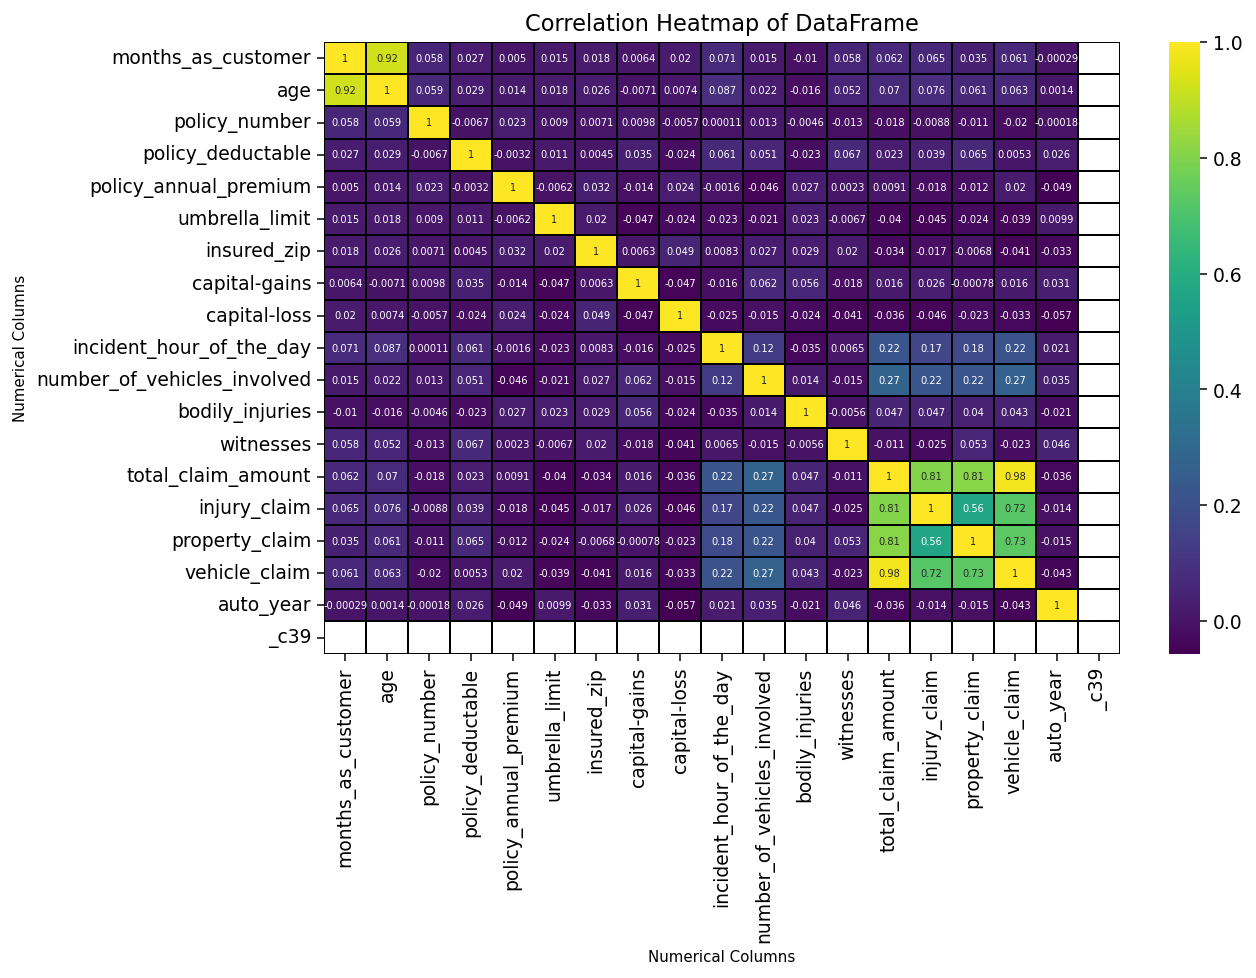

In [ ]:
g2 = create_corr_map(df)

In [ ]:
# Drop _c39
df = df.drop(columns=['_c39'])

Getting rid of colliniearity variables

In [ ]:
df.select_dtypes('number').isna().sum()

months_as_customer             0
age                            0
policy_number                  0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_zip                    0
capital-gains                  0
capital-loss                   0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
bodily_injuries                0
witnesses                      0
total_claim_amount             0
injury_claim                   0
property_claim                 0
vehicle_claim                  0
auto_year                      0
dtype: int64

In [ ]:
def variance_inflation_factor(df):
    '''
    Calculates Variance Inflation Factor for variables to determine collinearity.
    '''
    vif_df = pd.DataFrame(columns=['Feature', 'VIF'])
    features = df.select_dtypes('number').columns
    for i in range(len(features)):  # For each feature
        var_1 = df[features[i]]  # Select loop feature column
        var_other = df[features.drop(features[i])]  # All other data columns
        r_2 = sm.OLS(var_1, var_other).fit().rsquared  # R2 between feature and all other features
        vif = round(1/(1-r_2), 2)  # Calculate variance inflation factor
        vif_df.loc[i] = [features[i], vif]
    return vif_df.sort_values(by=['VIF'], ascending=False)

In [ ]:
vif_df = variance_inflation_factor(df)

C:\Users\clgme\AppData\Local\Temp/ipykernel_5884/3479185889.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  vif = round(1/(1-r_2), 2)  # Calculate variance inflation factor


In [ ]:
vif_df
# VIF values greater than 5 demonstrate extreme multicollinearity
# VIF values less than 5 but greater than 1 demonstrate moderate multicollinearity
# VIF values = 1 demonstrate low multicollinearity.

# From the heatmap of correlation:
    #    vehicle claim, property claim, injury claim, and total claim amount    
    #    have extremely high correlation.
    #    closer examination shows that total claim amount is a sum of vehicle
    #    claim, property claim, and injury claim. Drop total claim amount
    #    Also drop features with large number of distinct values that can't be converted to categories effectively (improve model variance.):
            # policy_number, incident location, insured zip, policy_bind_date, etc.
# Also variables that are not relevant
        # insured_hobbies, auto_model, auto_year, auto_make

,Feature,VIF
16,vehicle_claim,inf
15,property_claim,inf
14,injury_claim,inf
13,total_claim_amount,inf
17,auto_year,135.52
1,age,130.17
6,insured_zip,50.37
0,months_as_customer,28.05
4,policy_annual_premium,27.77
2,policy_number,5.55


In [ ]:
# for col in df.select_dtypes('number').columns:
#     plt.hist(df[df.select_dtypes('number').columns][col], edgecolor='black', linewidth=1.2)
#     plt.title(col)
#     plt.show()

# Exploring Fraud Reported by Different Categorical Variables

In [ ]:
df.select_dtypes('object').columns

Index(['policy_bind_date', 'policy_state', 'policy_csl', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'incident_date', 'incident_type',
       'collision_type', 'incident_severity', 'authorities_contacted',
       'incident_state', 'incident_city', 'incident_location',
       'property_damage', 'police_report_available', 'auto_make', 'auto_model',
       'fraud_reported'],
      dtype='object')

Text(0, 0.5, 'Count')

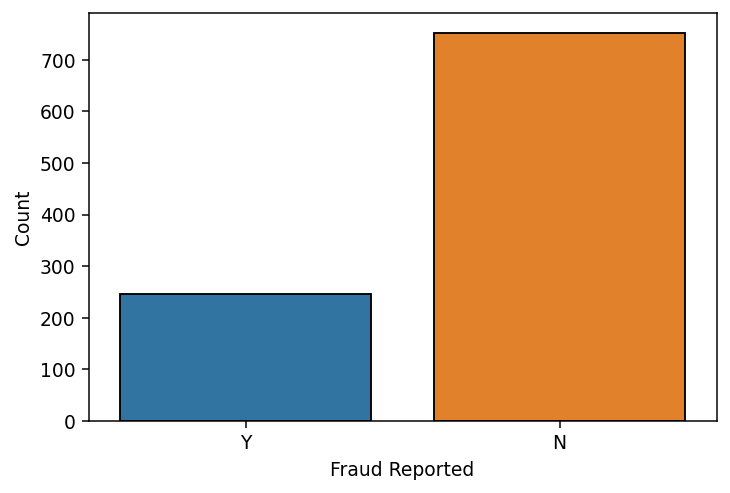

In [ ]:
sns.countplot(data=df, x='fraud_reported', edgecolor='black')
plt.xlabel('Fraud Reported')
plt.ylabel('Count')

# Skewed data for reported fraud, many more cases of no than yes

In [ ]:
def visualize_categorical(df, variable, size_row=15, size_col=7):
    '''
    Creates a bar chart visual for count of fraud reported (yes or no) of a specified categorical variable.
    '''
    plt.figure(figsize=(size_row, size_col))
    sns.countplot(data=df, x=variable, hue='fraud_reported', edgecolor='black')
    plt.legend(loc=2, bbox_to_anchor=(1,1), title='Fraud Reported')
    plt.title(variable)
    plt.ylabel('Count')
    plt.tight_layout()

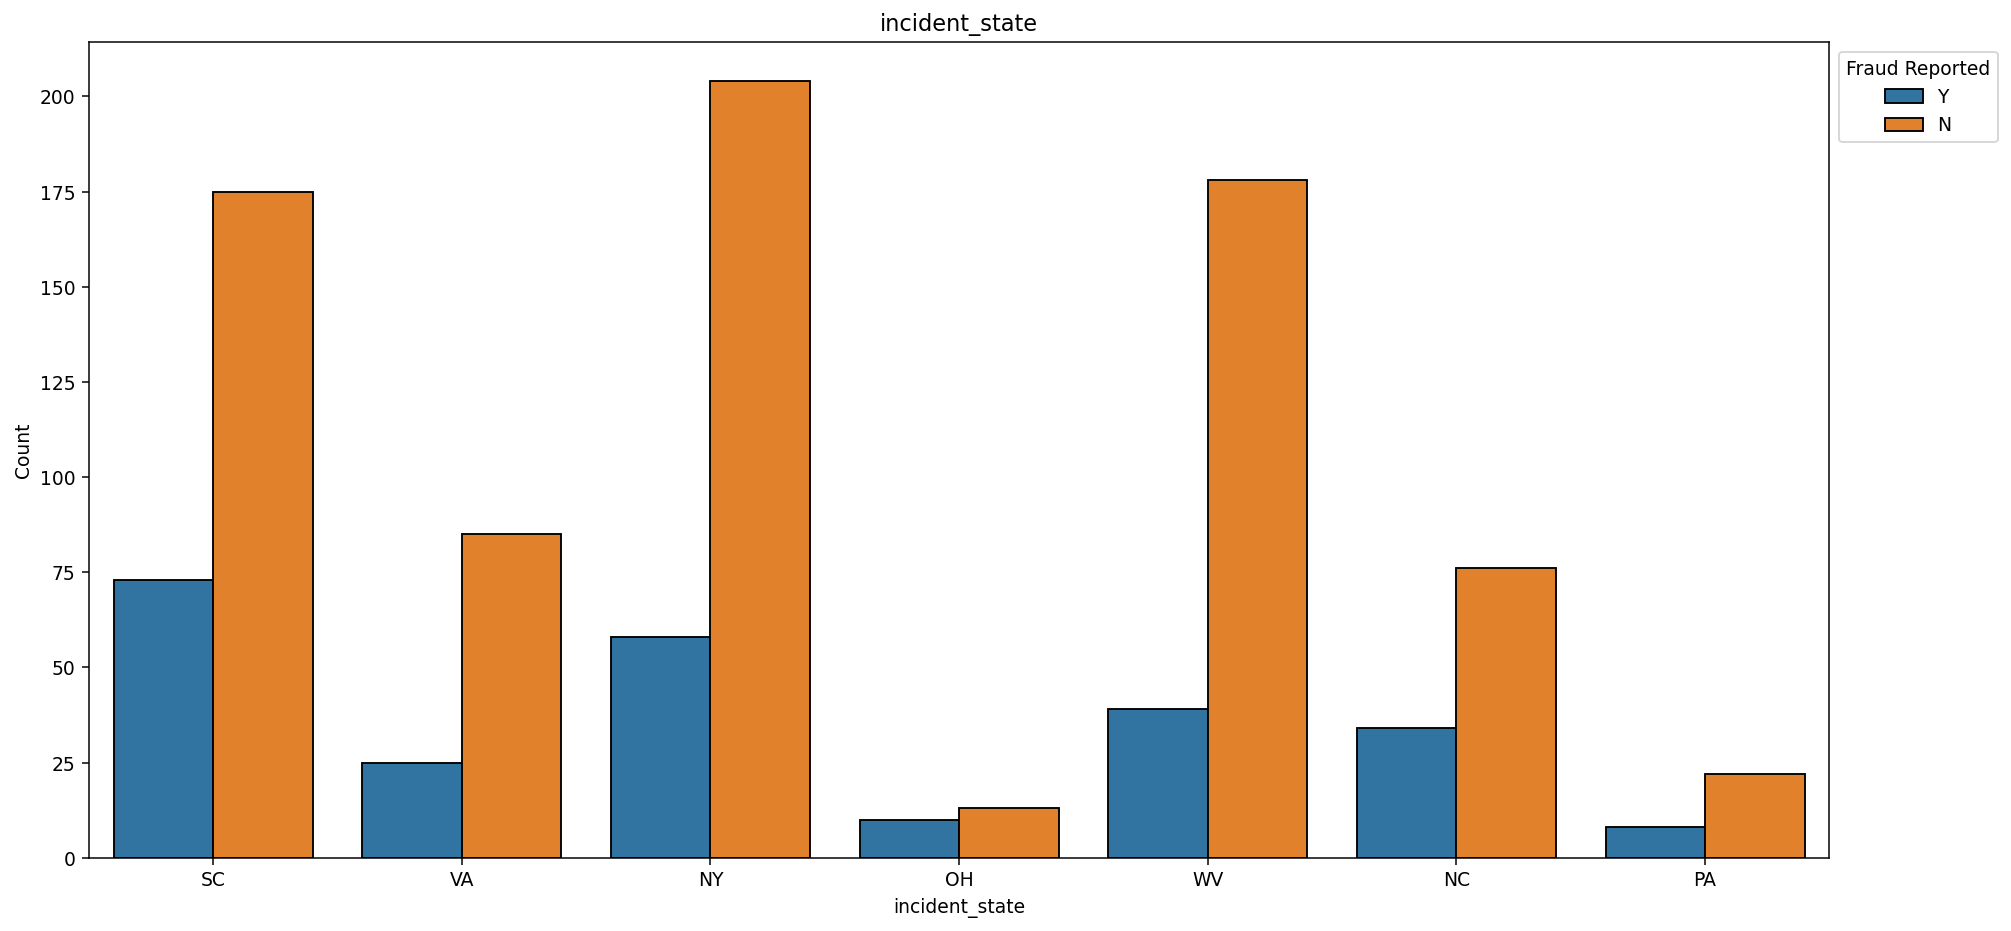

In [ ]:
visualize_categorical(df, 'incident_state')
# Ohio is more even than the other states

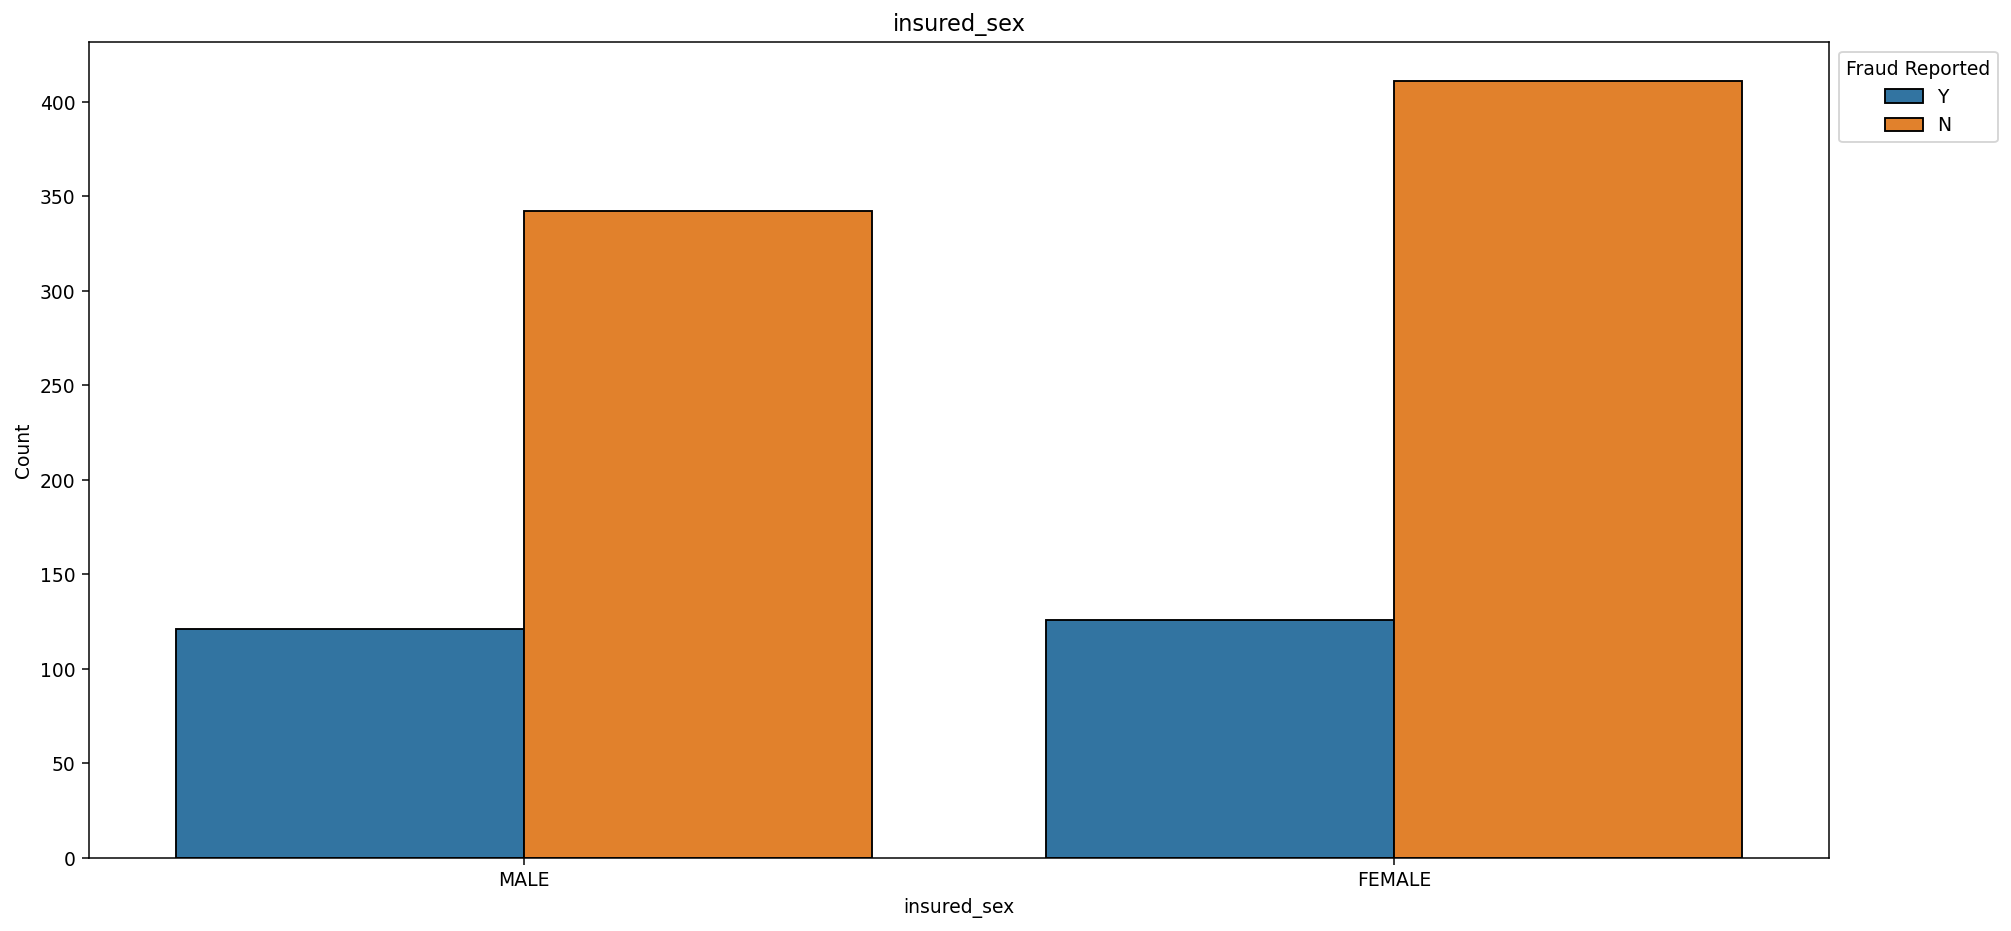

In [ ]:
visualize_categorical(df, 'insured_sex')

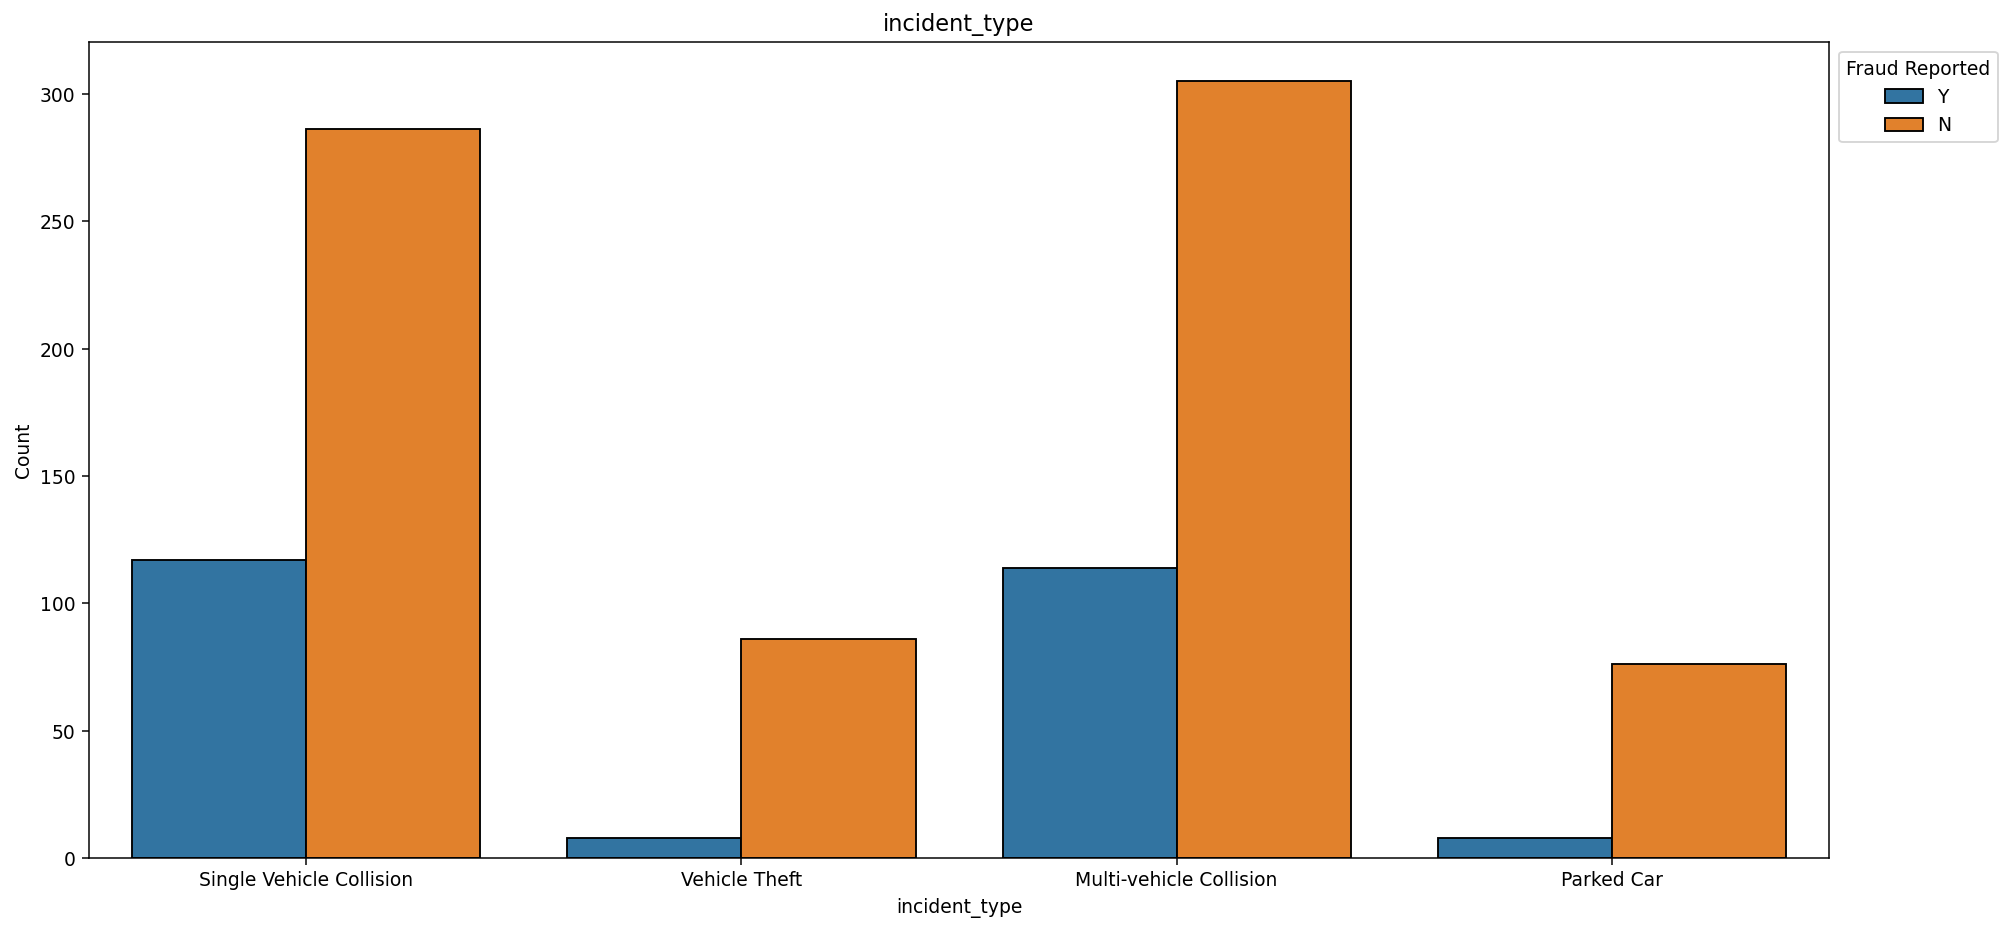

In [ ]:
visualize_categorical(df, 'incident_type')

# Multi-vehicle collision and single vehicle collision are much higher fraudulent reports than vehicle theft and parked car

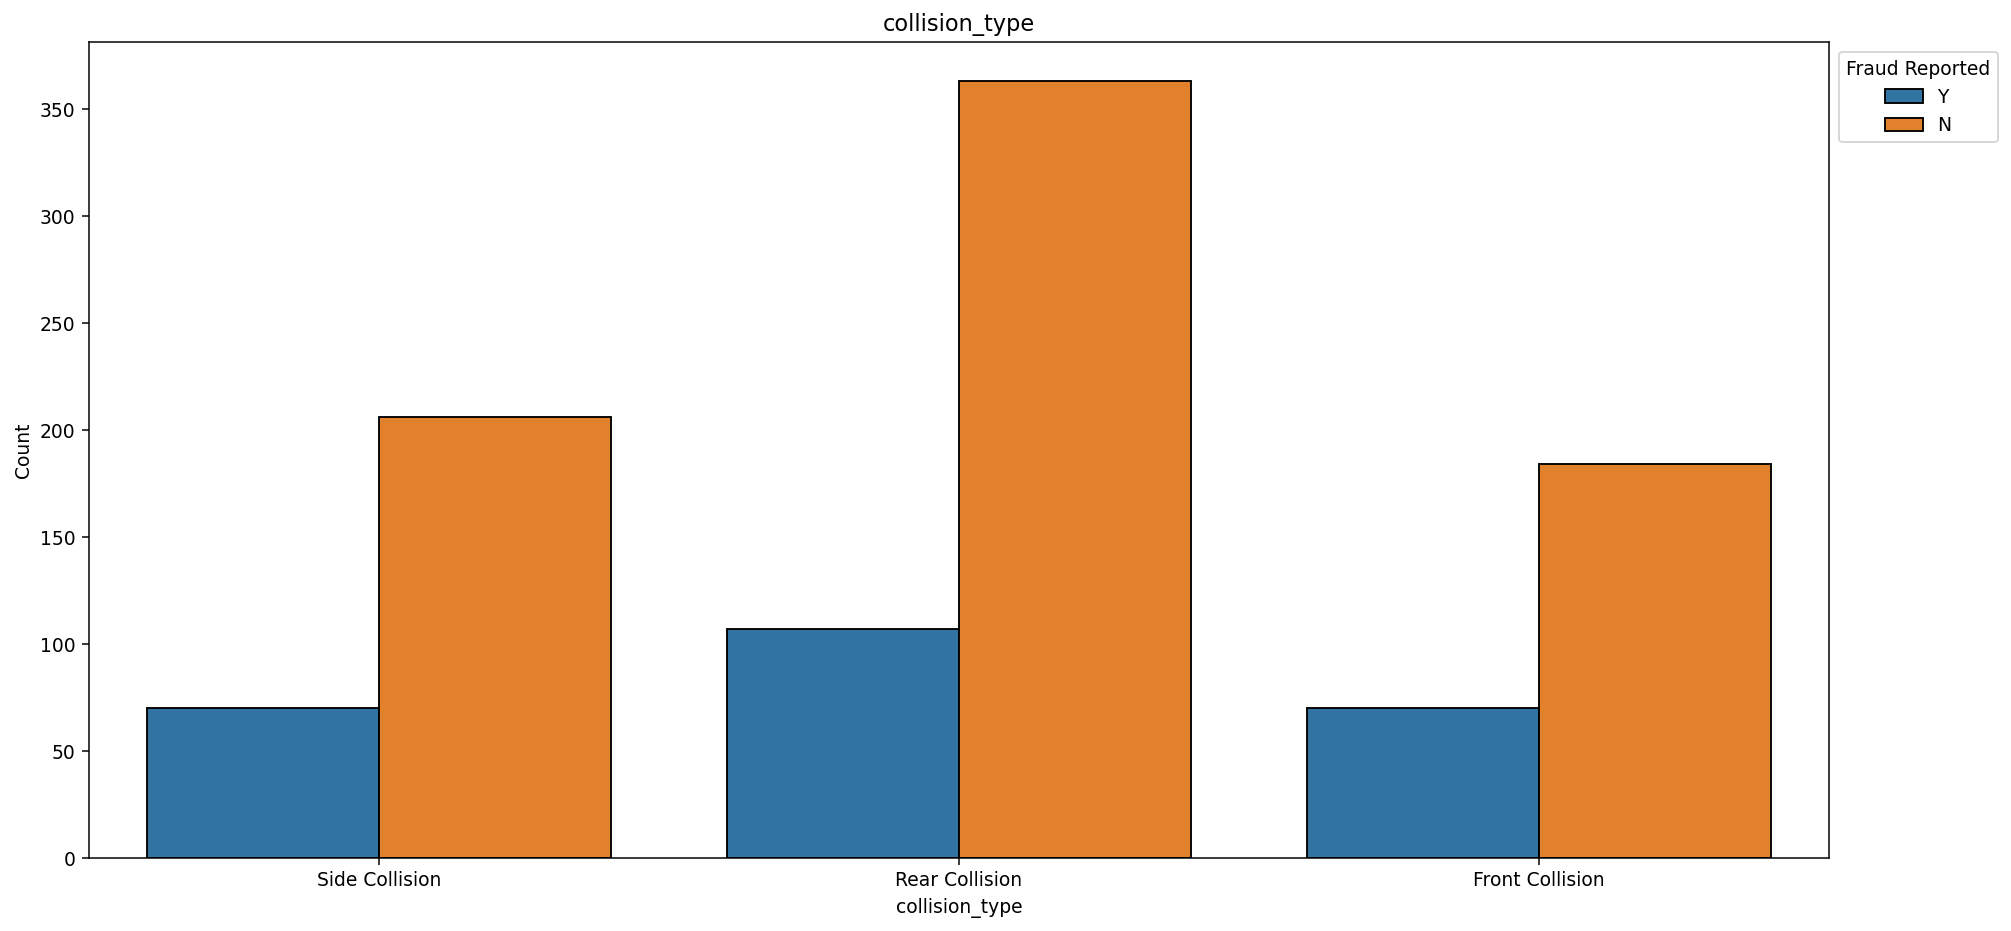

In [ ]:
visualize_categorical(df, 'collision_type')

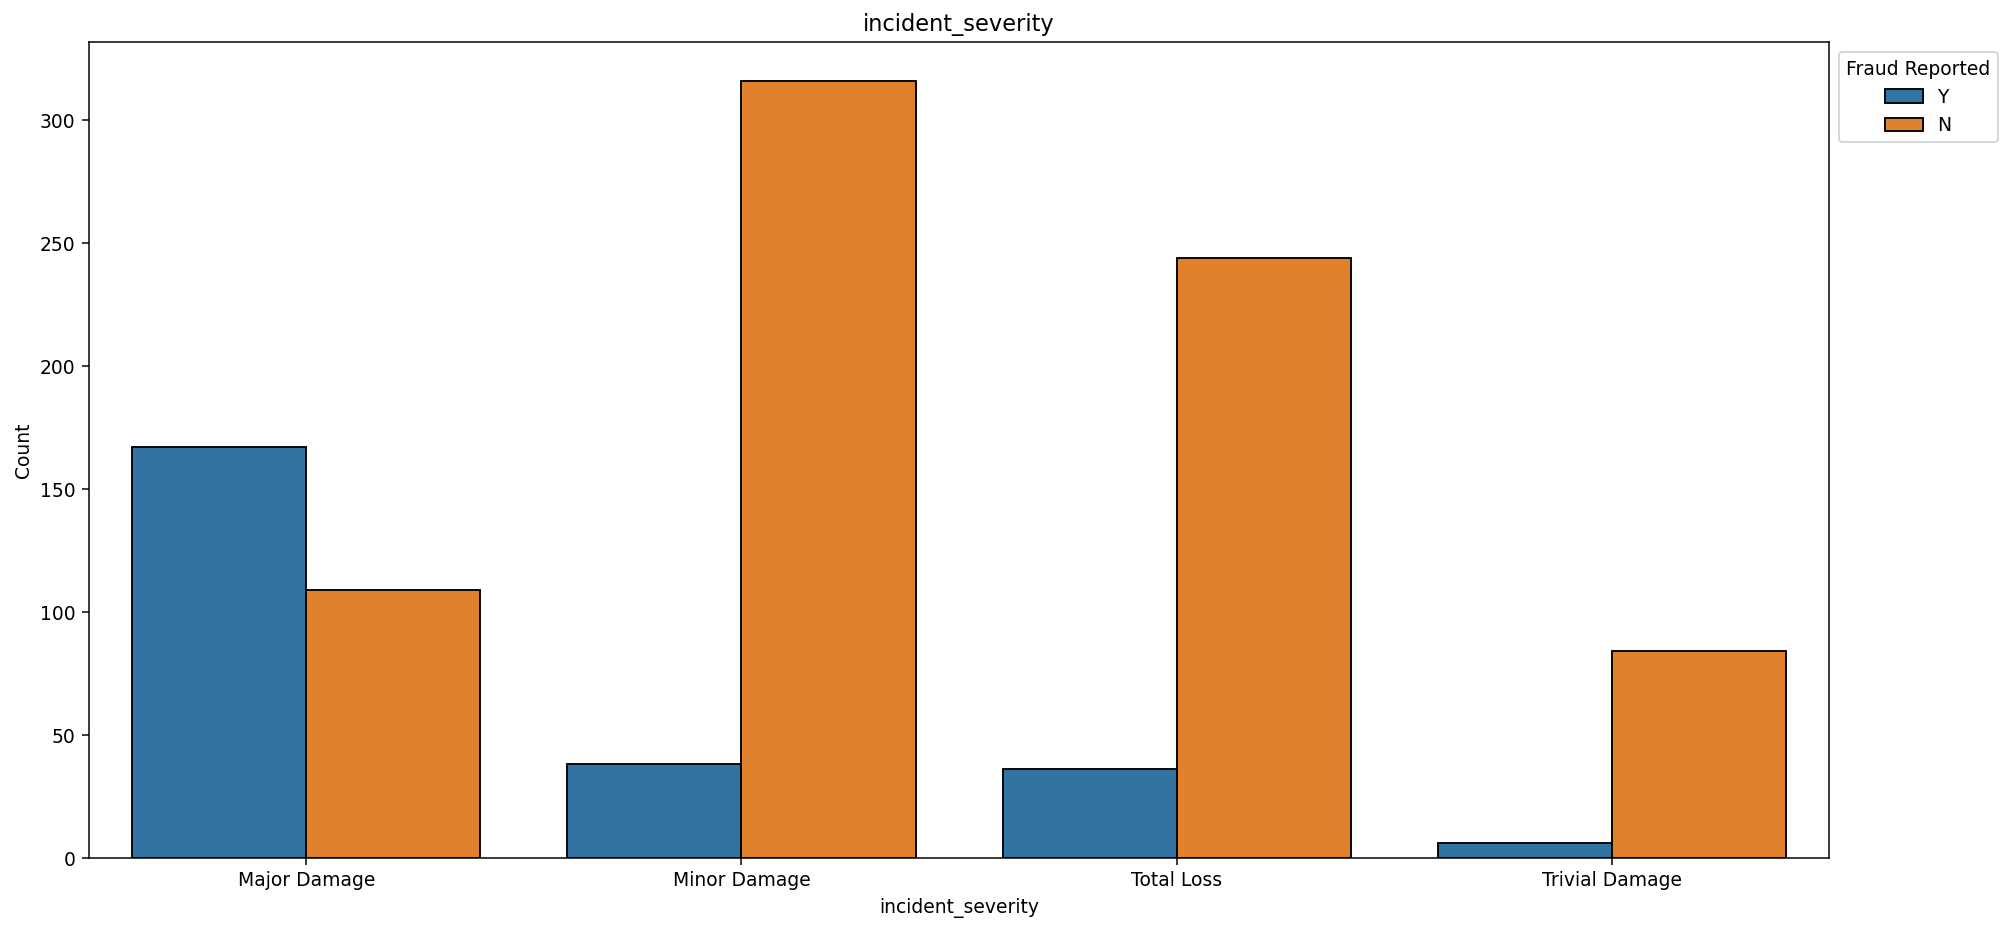

In [ ]:
visualize_categorical(df, 'incident_severity')

# Major damage is reported as fraud much more often than minor damage, total loss, and trivial damage. Smaller damages are probably not worth fradulently reporting. Total loss also implies that it would cost more money for you to repair the car than to replace the car therefore there are probably fewer fradulent reports for this.

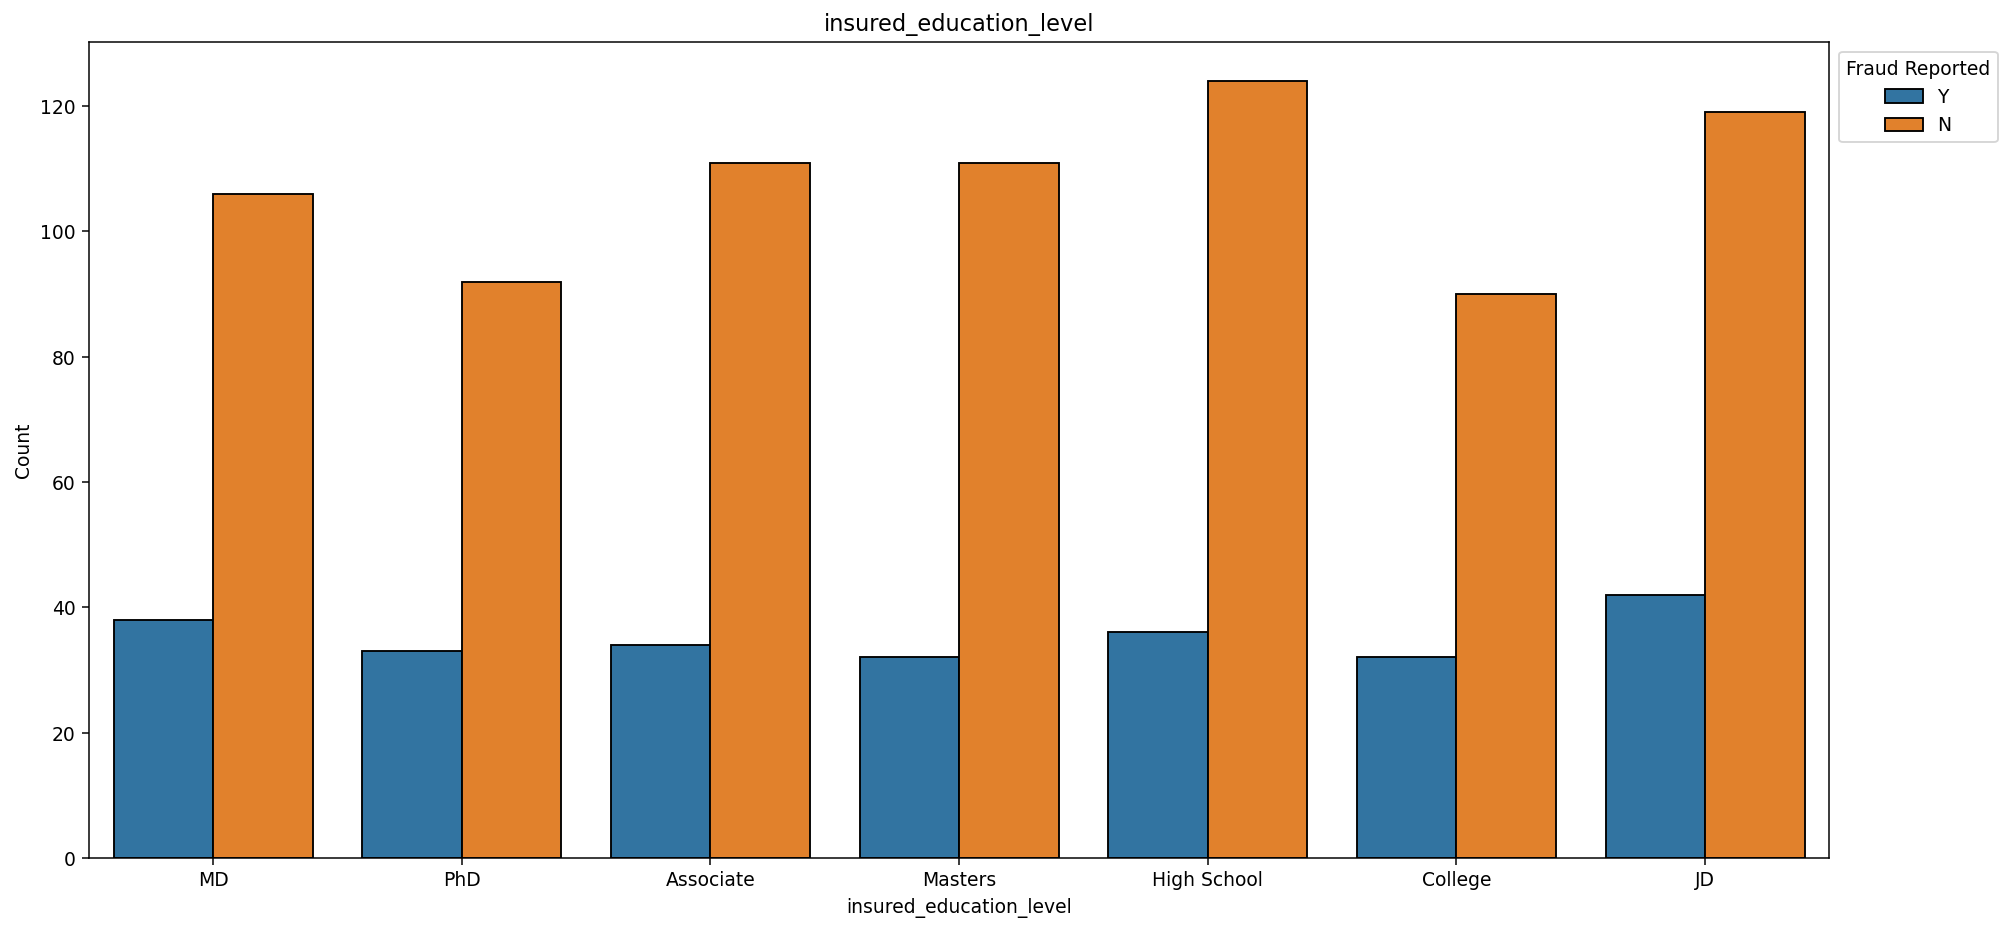

In [ ]:
visualize_categorical(df, 'insured_education_level')

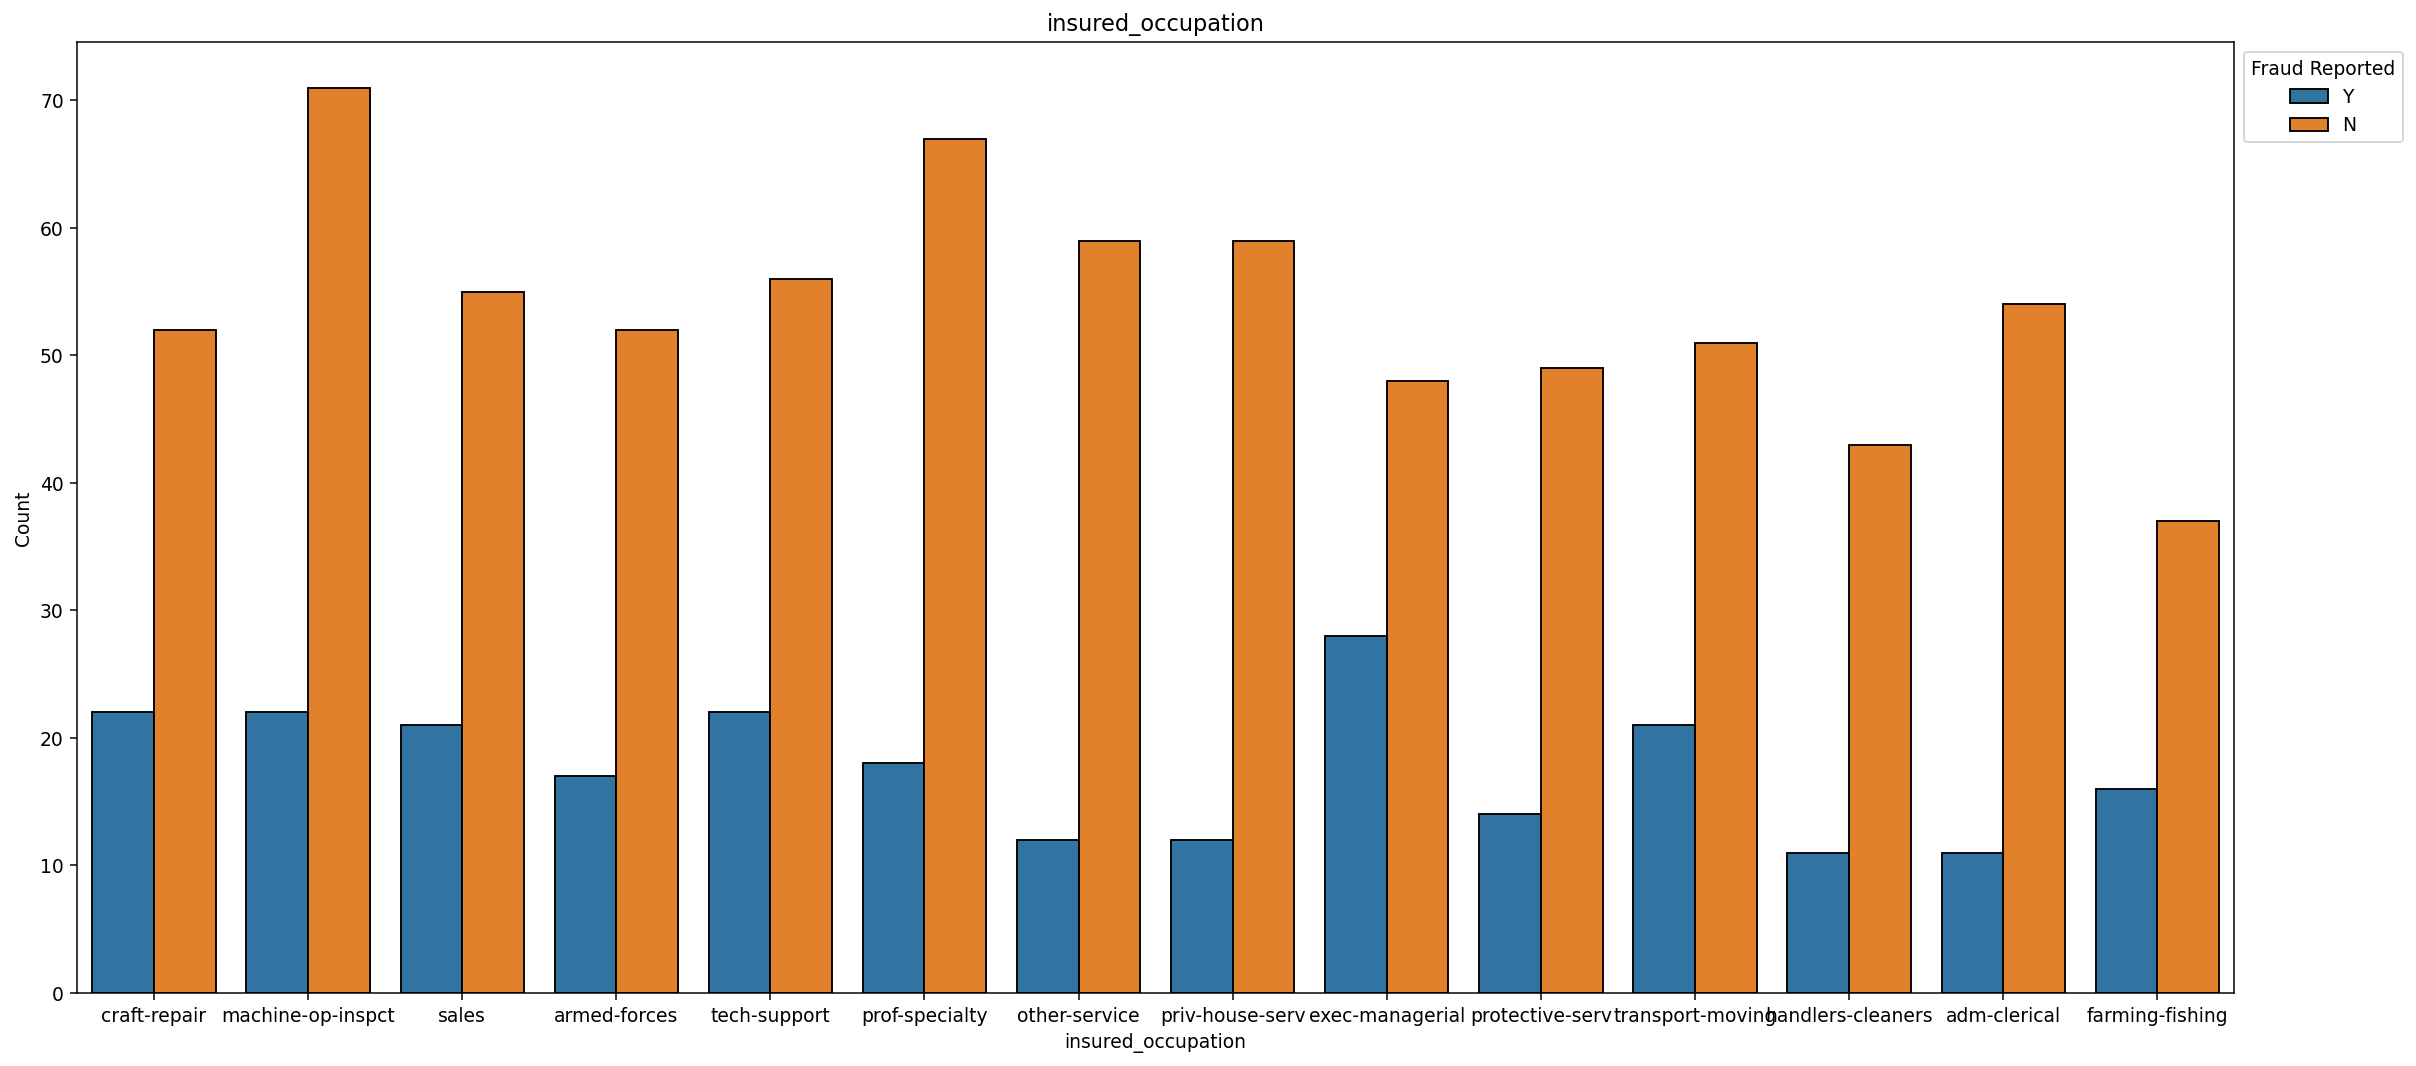

In [ ]:
visualize_categorical(df, 'insured_occupation', size_row=18, size_col=8)
# exec-managerial is a bit higher on the fraud reported yes, with a slightly lower than other occupations for fraud reported no.

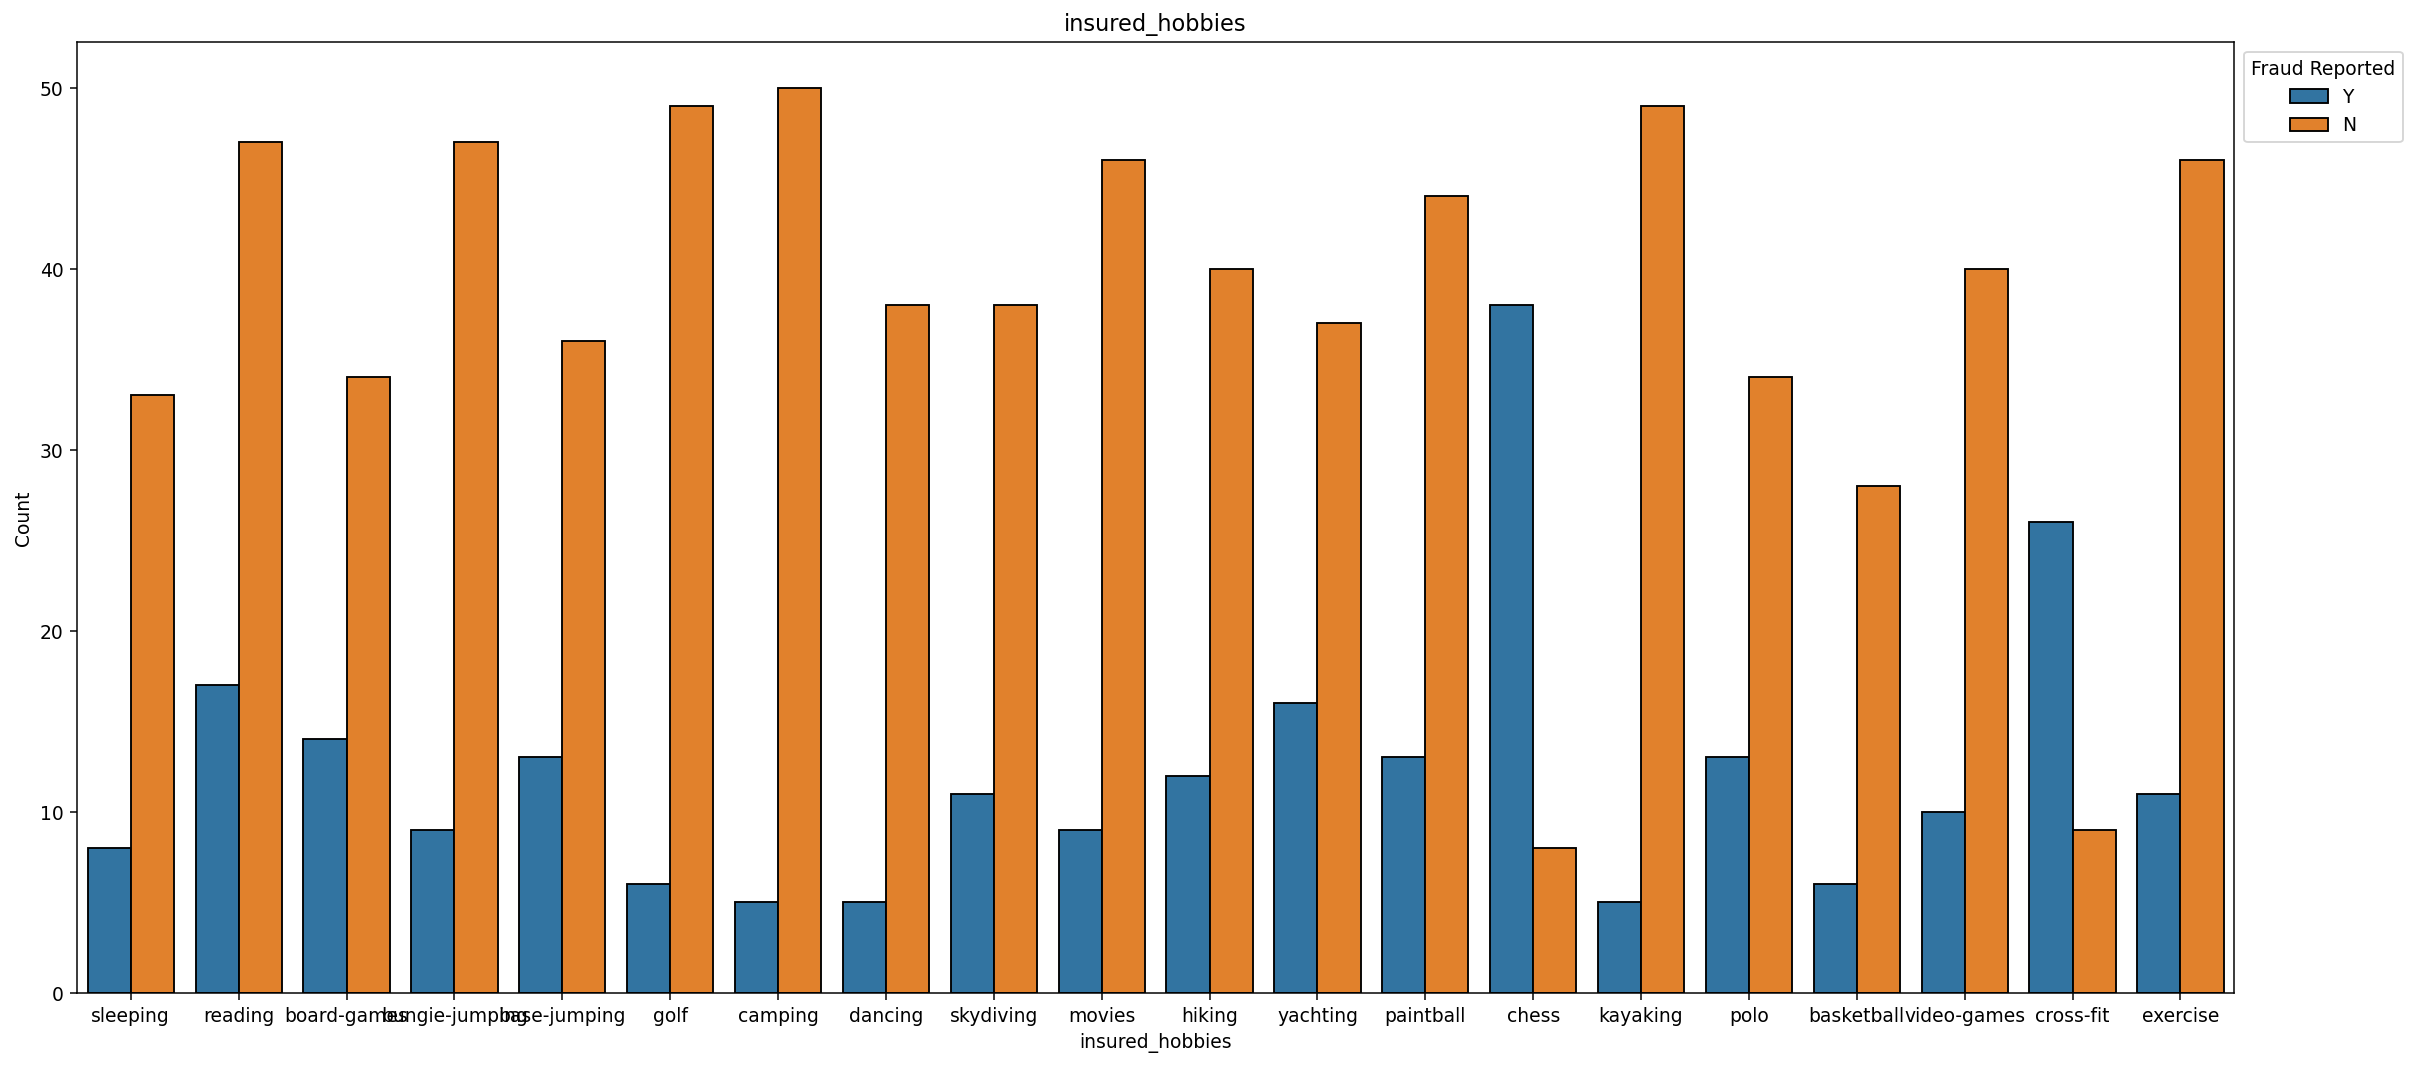

In [ ]:
visualize_categorical(df, 'insured_hobbies', size_row=18, size_col=8)

# Chess and cross fit are the two hobbies with higher yes than no.

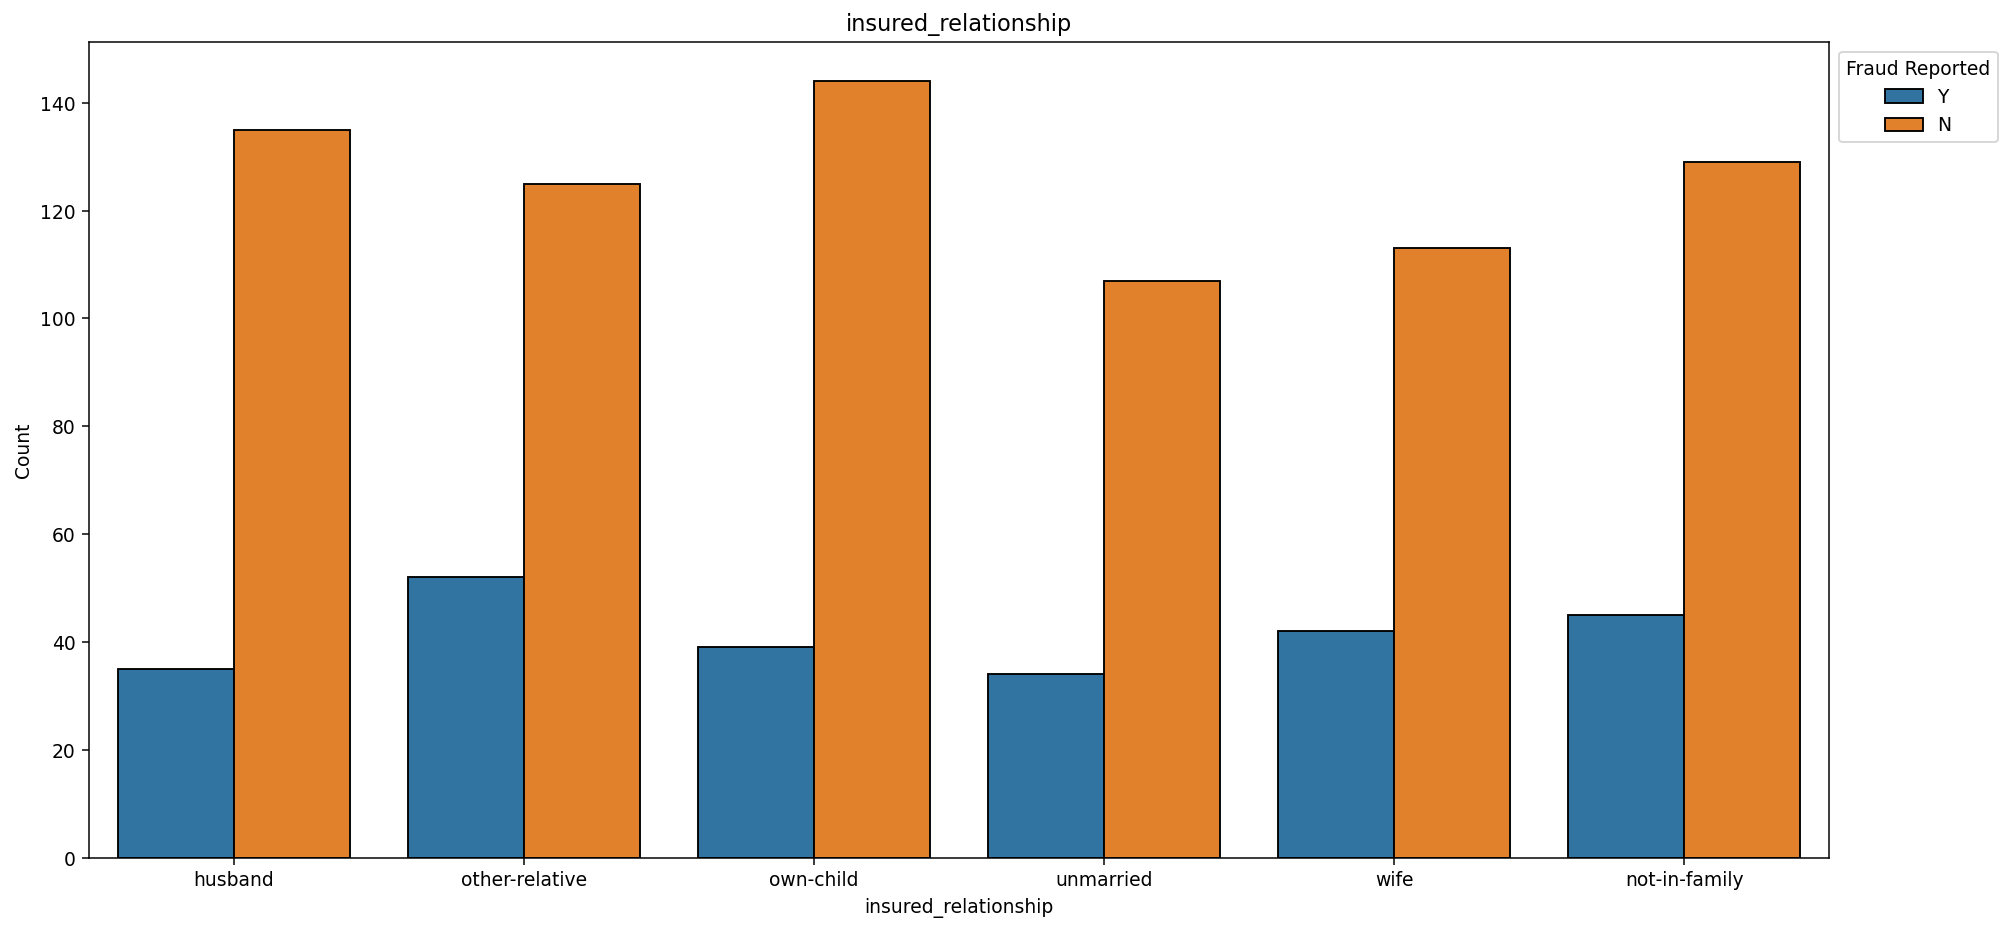

In [ ]:
visualize_categorical(df, 'insured_relationship')

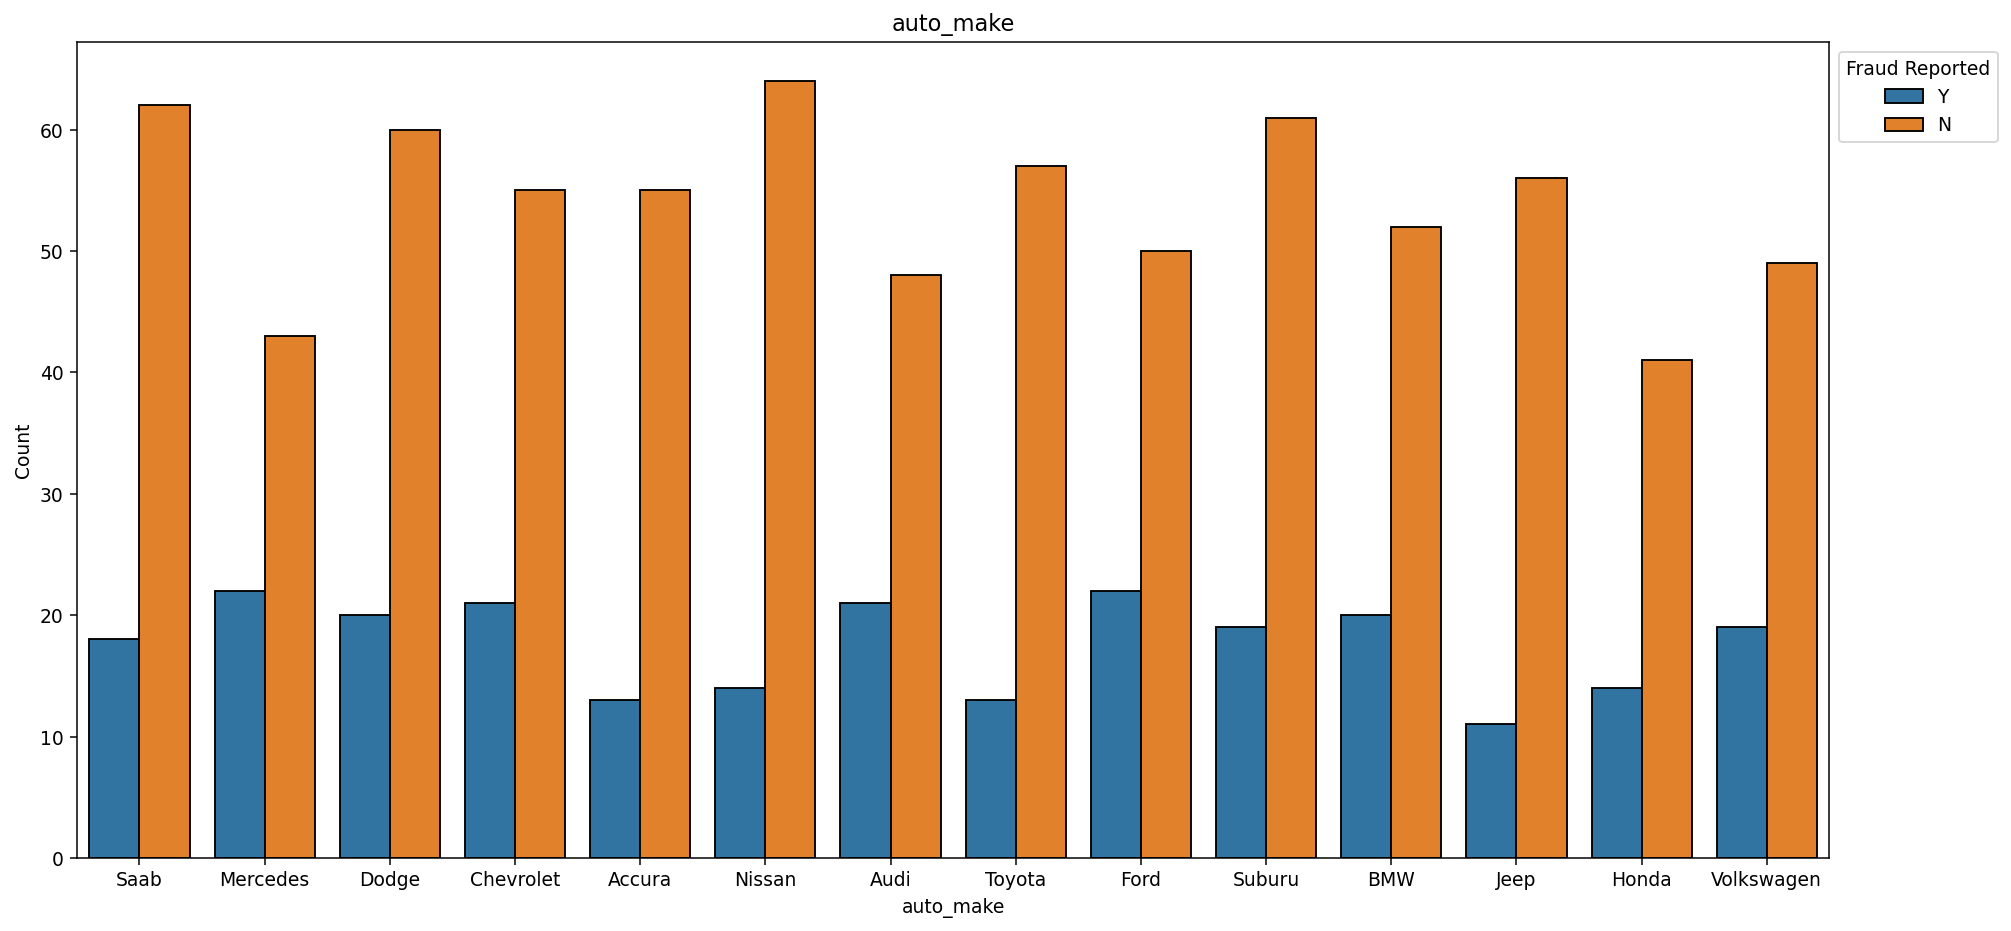

In [ ]:
visualize_categorical(df, 'auto_make')

From quick visual exploration, some categorical features of note are insured hobby, incident type, insured occupation, and incident state

# Exploring Fraud Reported by Different Numerical Variables

In [ ]:
df.select_dtypes('number').columns

Index(['months_as_customer', 'age', 'policy_number', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip',
       'capital-gains', 'capital-loss', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'bodily_injuries', 'witnesses',
       'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim',
       'auto_year'],
      dtype='object')

In [ ]:
def visualize_numerical(df, variable, row=10, col=6):
    '''
    Visualizes specified numerical variable
    '''
    plt.figure(figsize=(row, col))
    sns.histplot(data=df, hue='fraud_reported', x=variable)
    plt.legend(labels=['N', 'Y'], loc=2, bbox_to_anchor=(1,1), title='Fraud Reported')
    plt.title(variable)
    plt.ylabel('Count')
    plt.tight_layout()

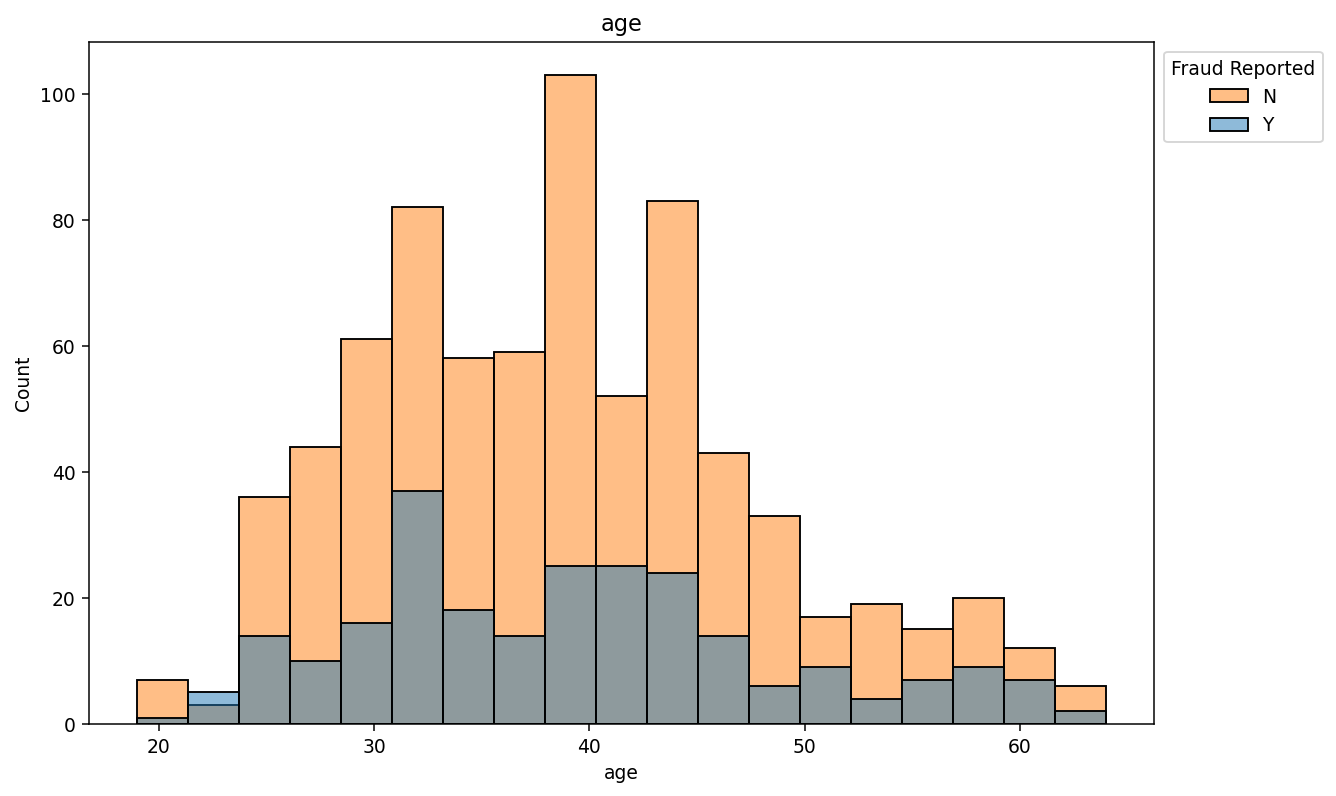

In [ ]:
visualize_numerical(df, 'age')

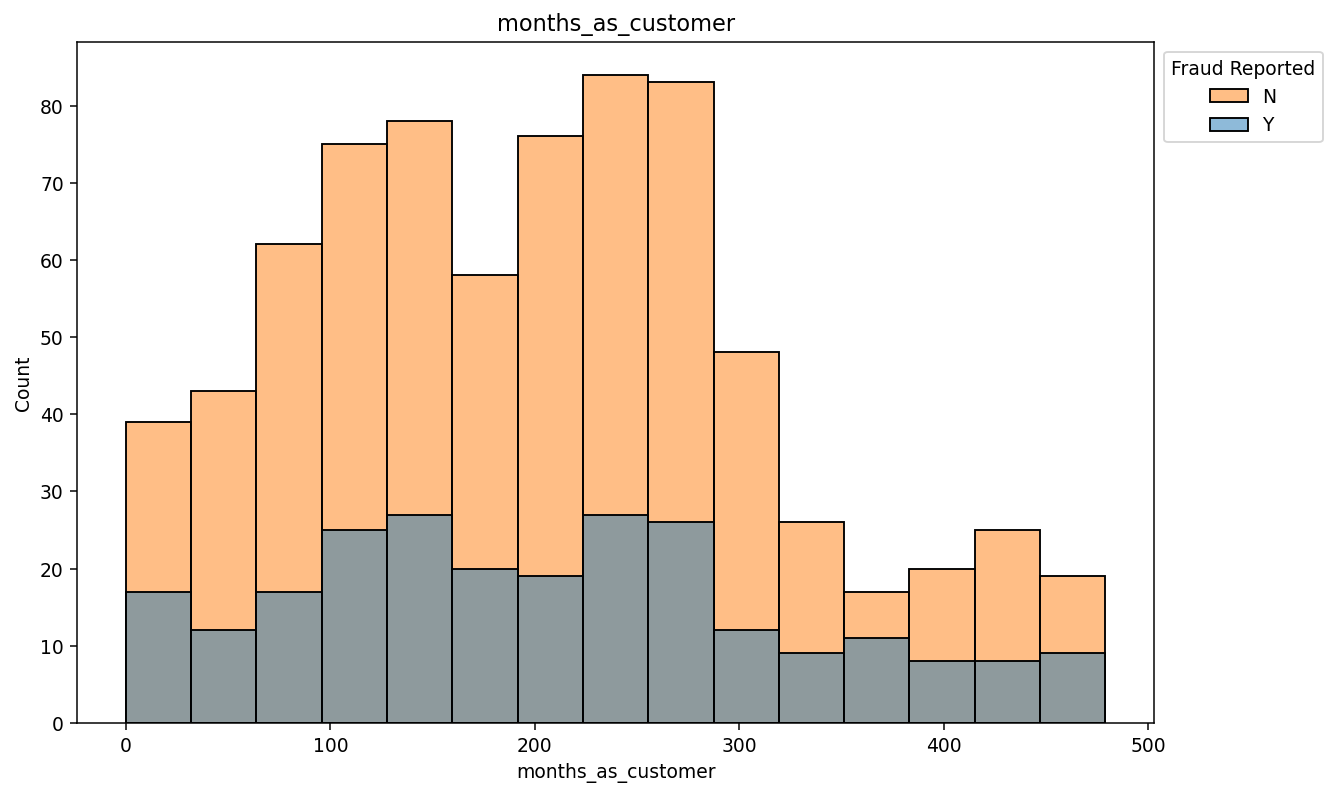

In [ ]:
visualize_numerical(df, 'months_as_customer')
# Age seems to have a more interesting trend than months as a customer, with customers in 30 - 40 years of age exhibiting higher fraud counts

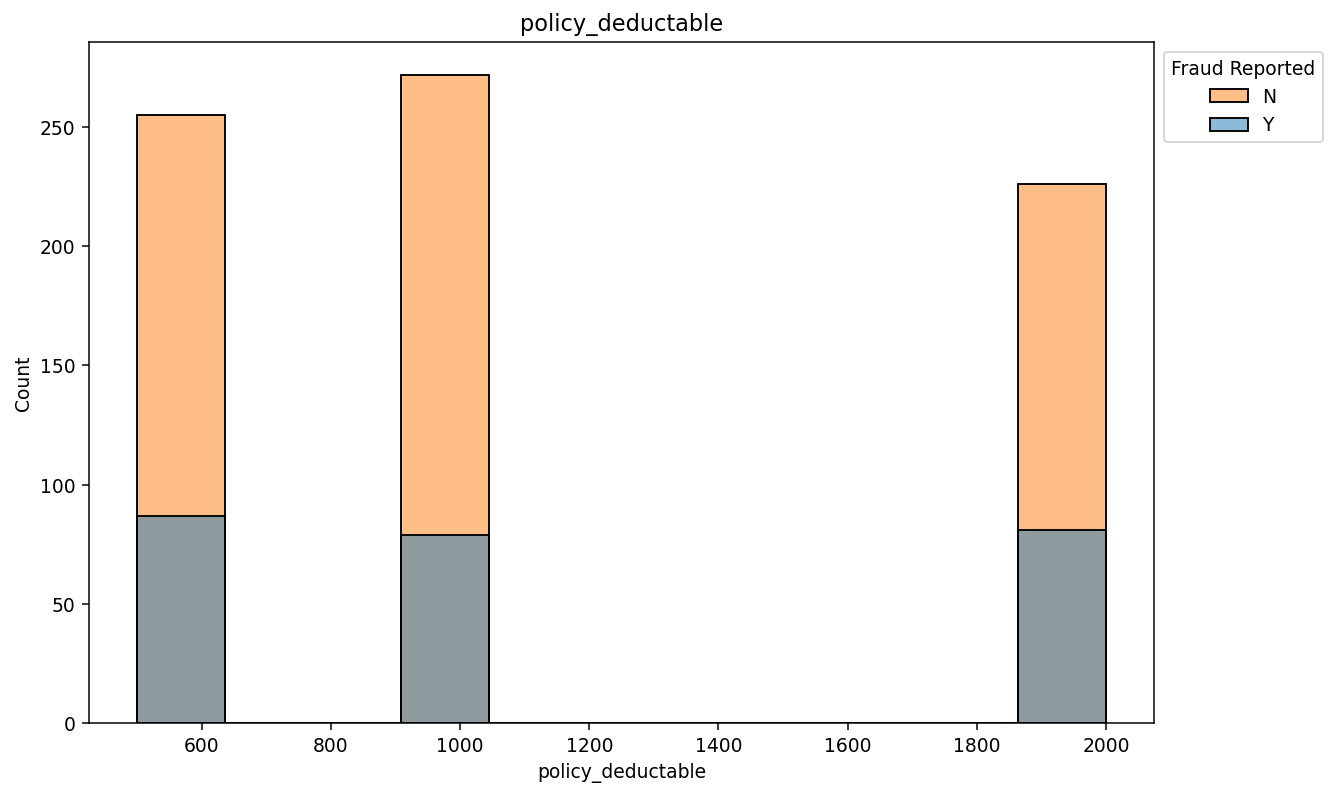

In [ ]:
visualize_numerical(df, 'policy_deductable')
# About the same for all

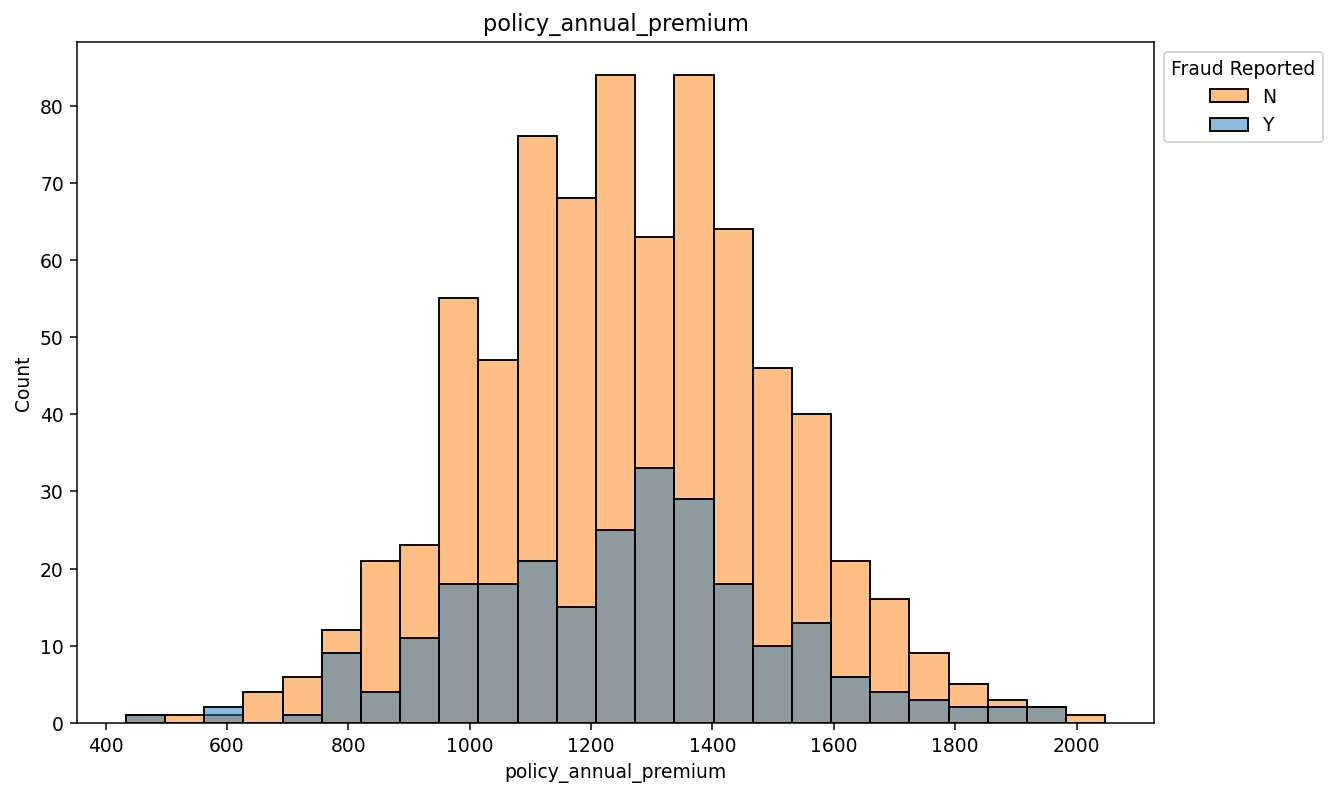

In [ ]:
visualize_numerical(df, 'policy_annual_premium')
# Generally same distribution for both.

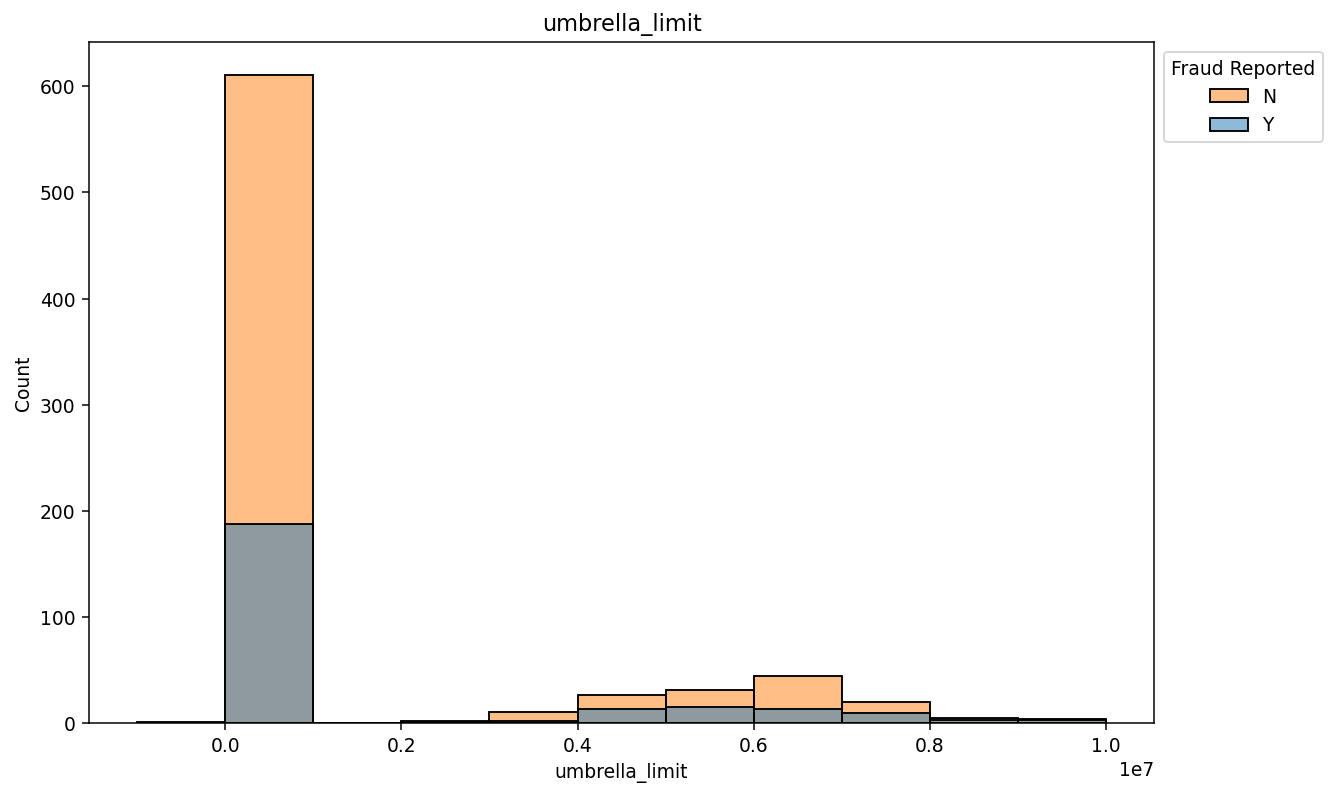

In [ ]:
visualize_numerical(df, 'umbrella_limit')
# Most fraud report cases are lower umbrella limit

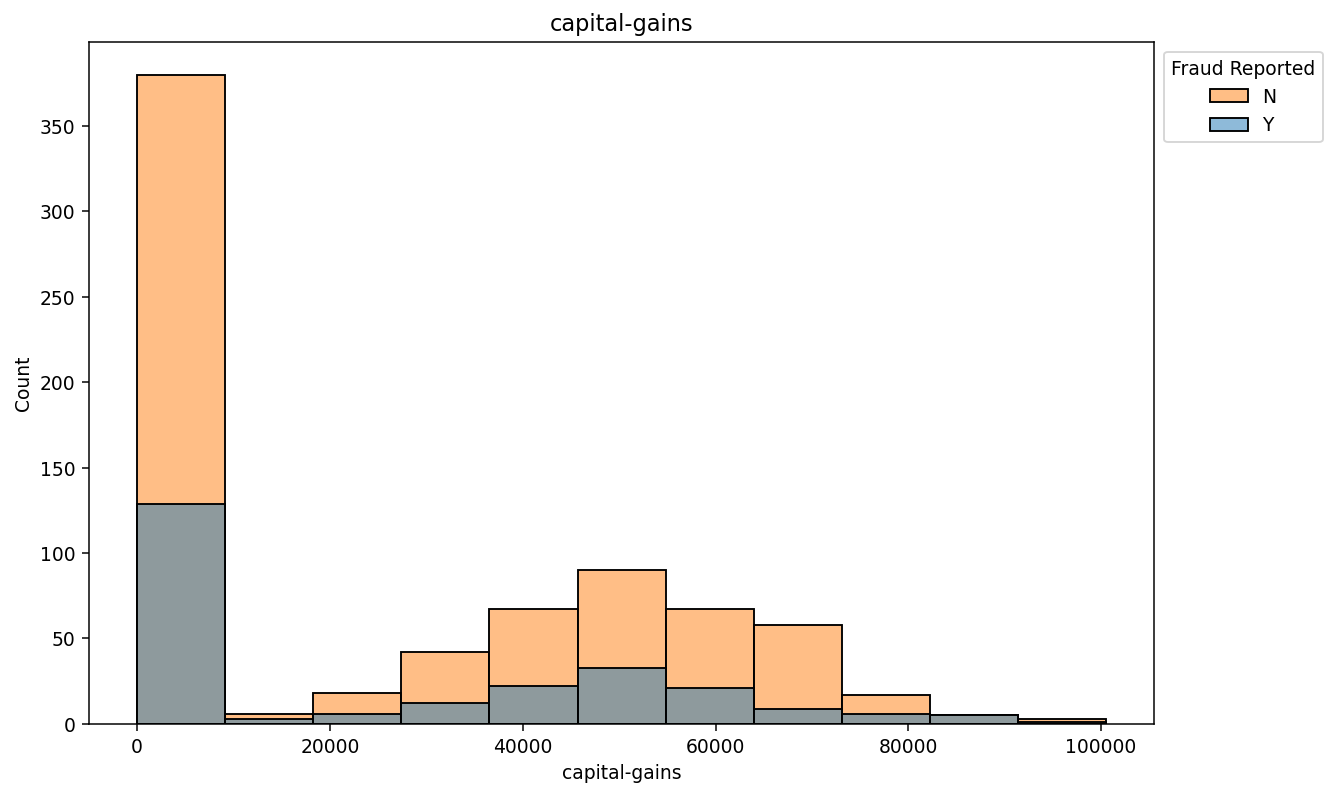

In [ ]:
visualize_numerical(df, 'capital-gains')
# Skewed distribution again, more cases of both no and yes reported for lower end range of capital_gains

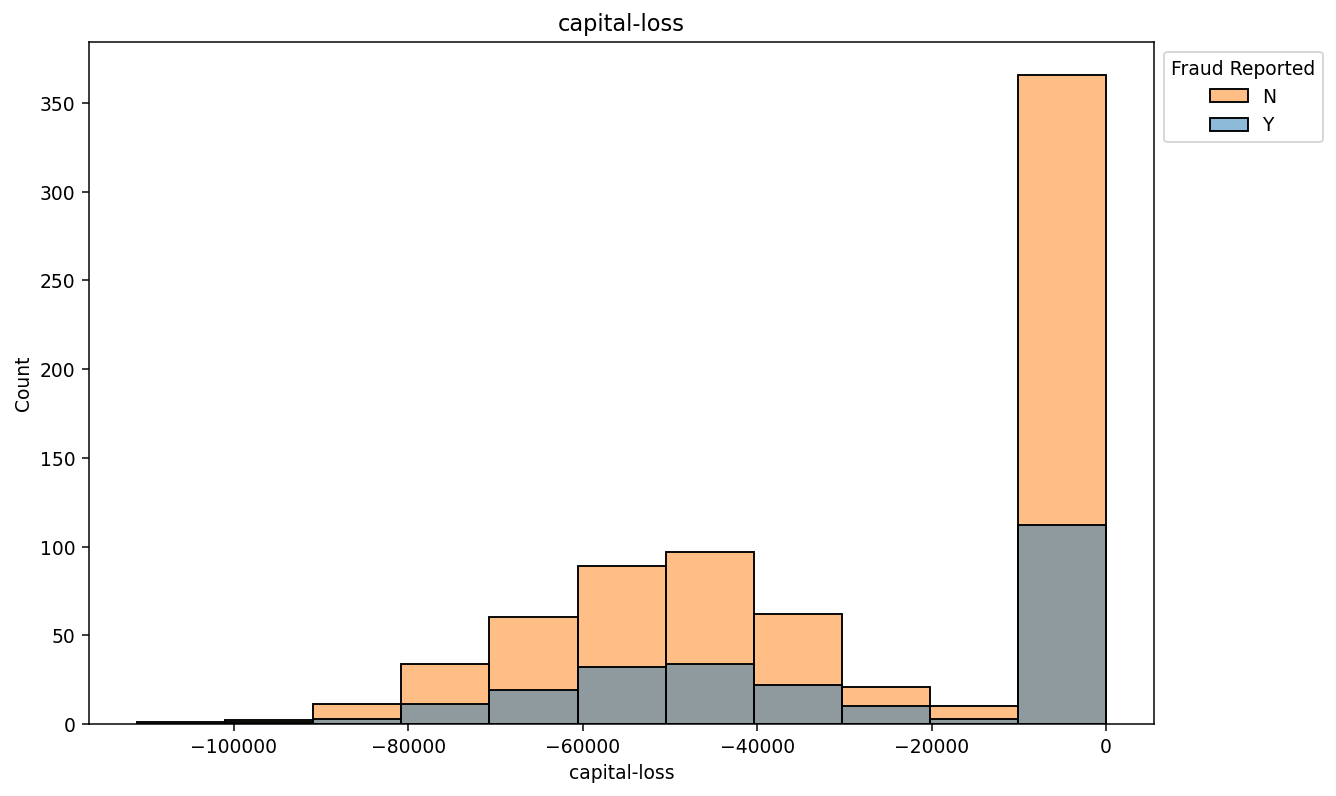

In [ ]:
visualize_numerical(df, 'capital-loss')
# Skewed, capital loss near 0 have higher cases of both.

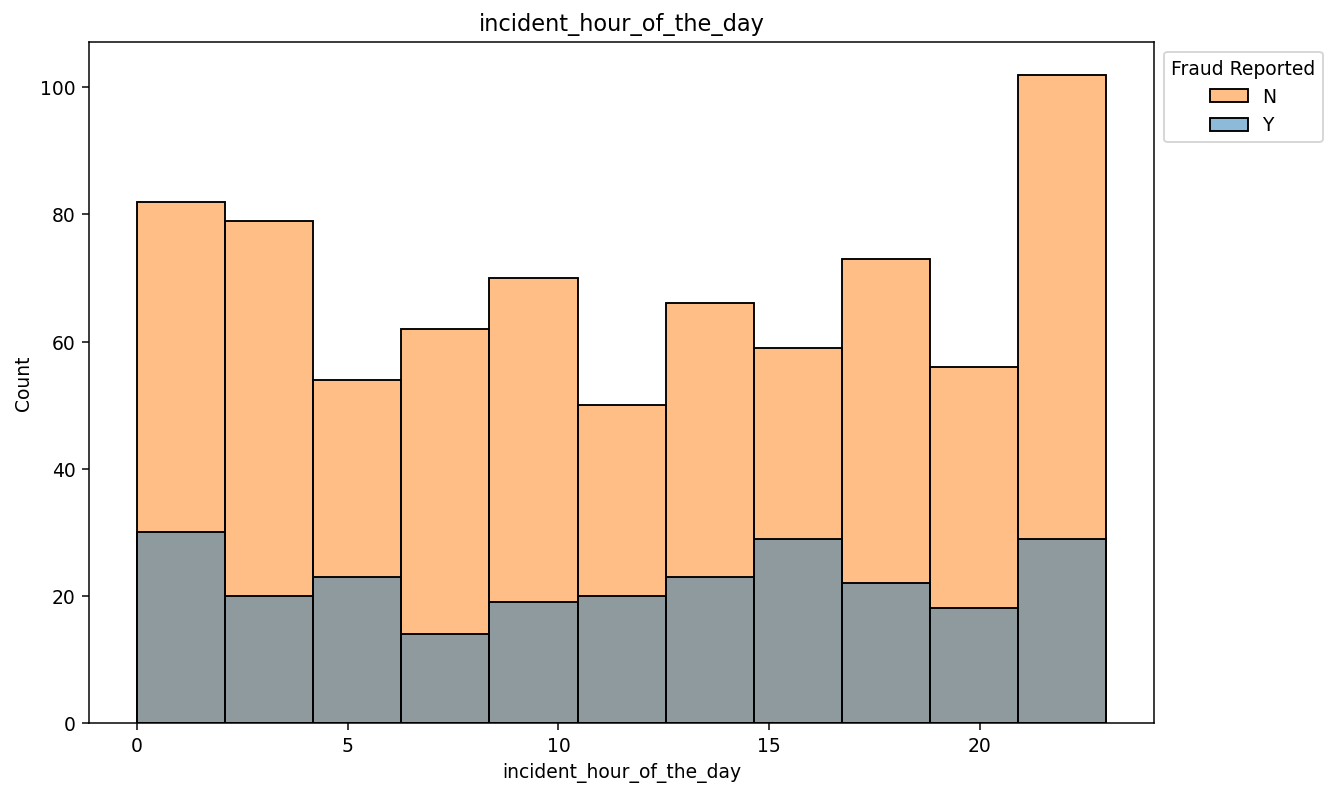

In [ ]:
visualize_numerical(df, 'incident_hour_of_the_day')
# Earlier and later hours of the day seem to have higher fraud reported then middle hours of the day 


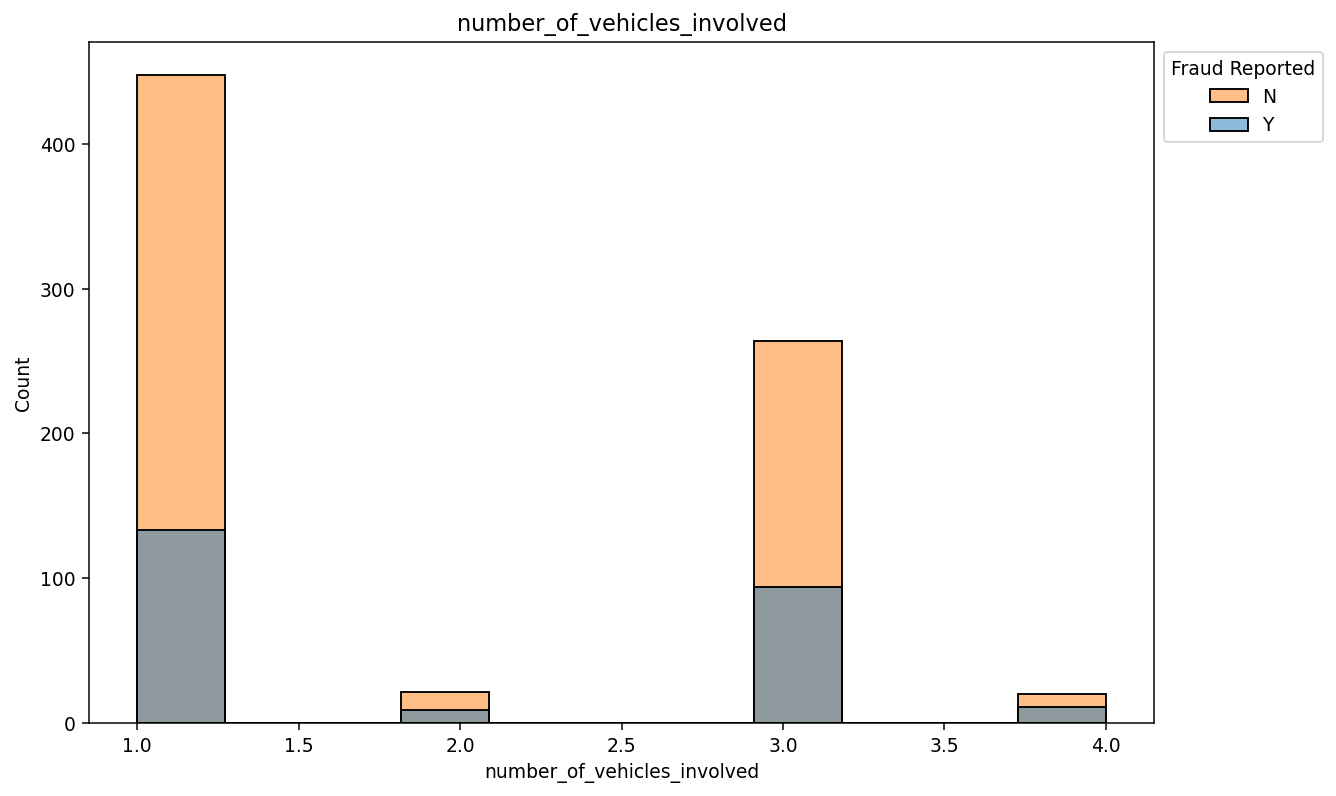

In [ ]:
visualize_numerical(df, 'number_of_vehicles_involved')
# Inconsistent, 1 and 3 seem to exhibit higher fraud reported.

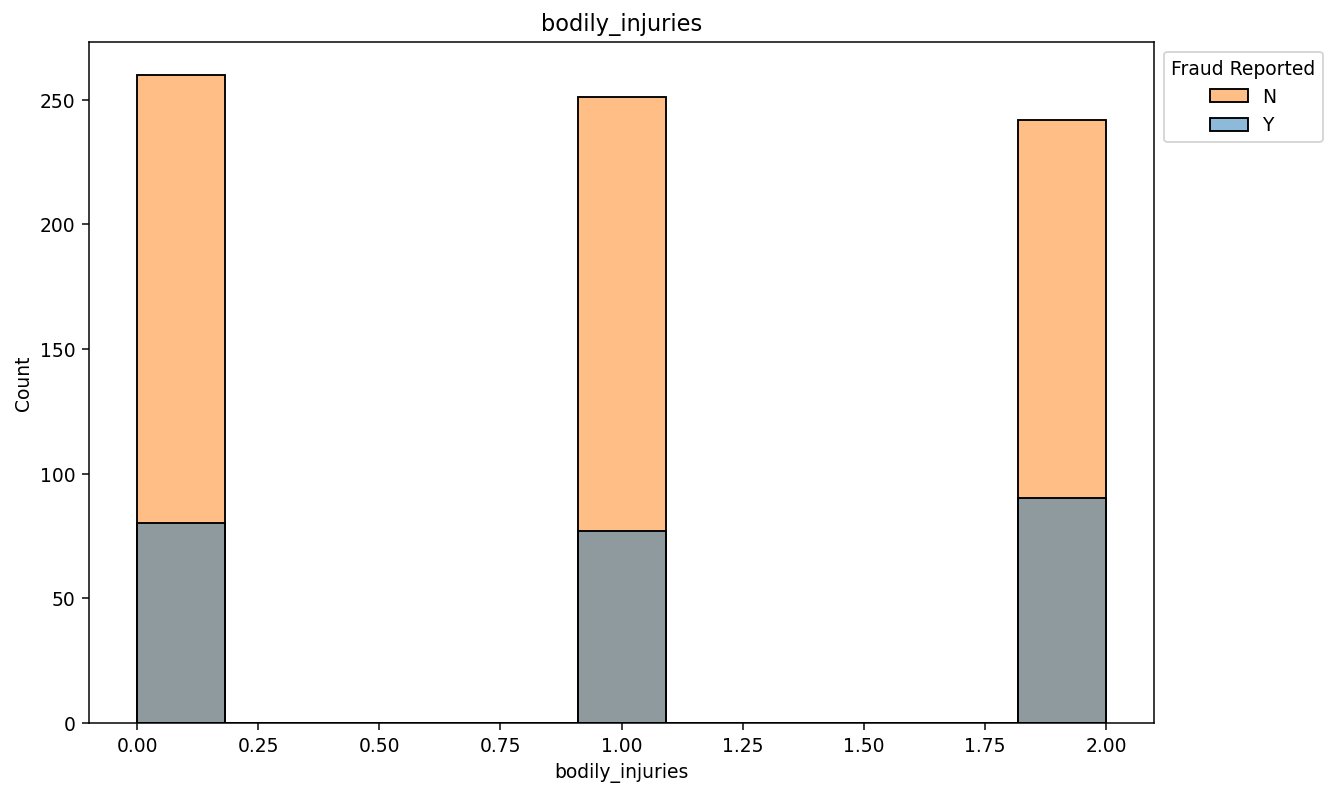

In [ ]:
visualize_numerical(df, 'bodily_injuries')
# Consistent

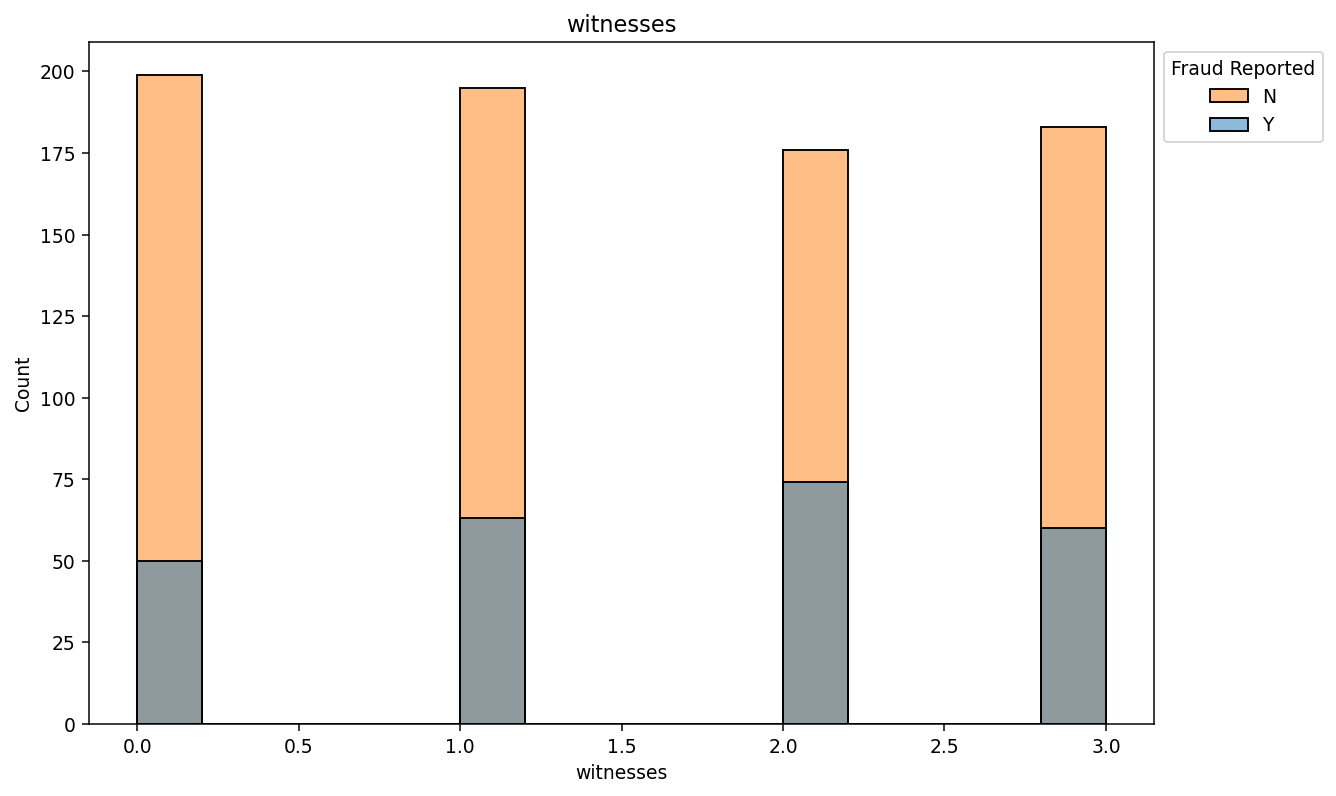

In [ ]:
visualize_numerical(df, 'witnesses')
# Surprisingly witnesses do not have much of a trend with fraud reported

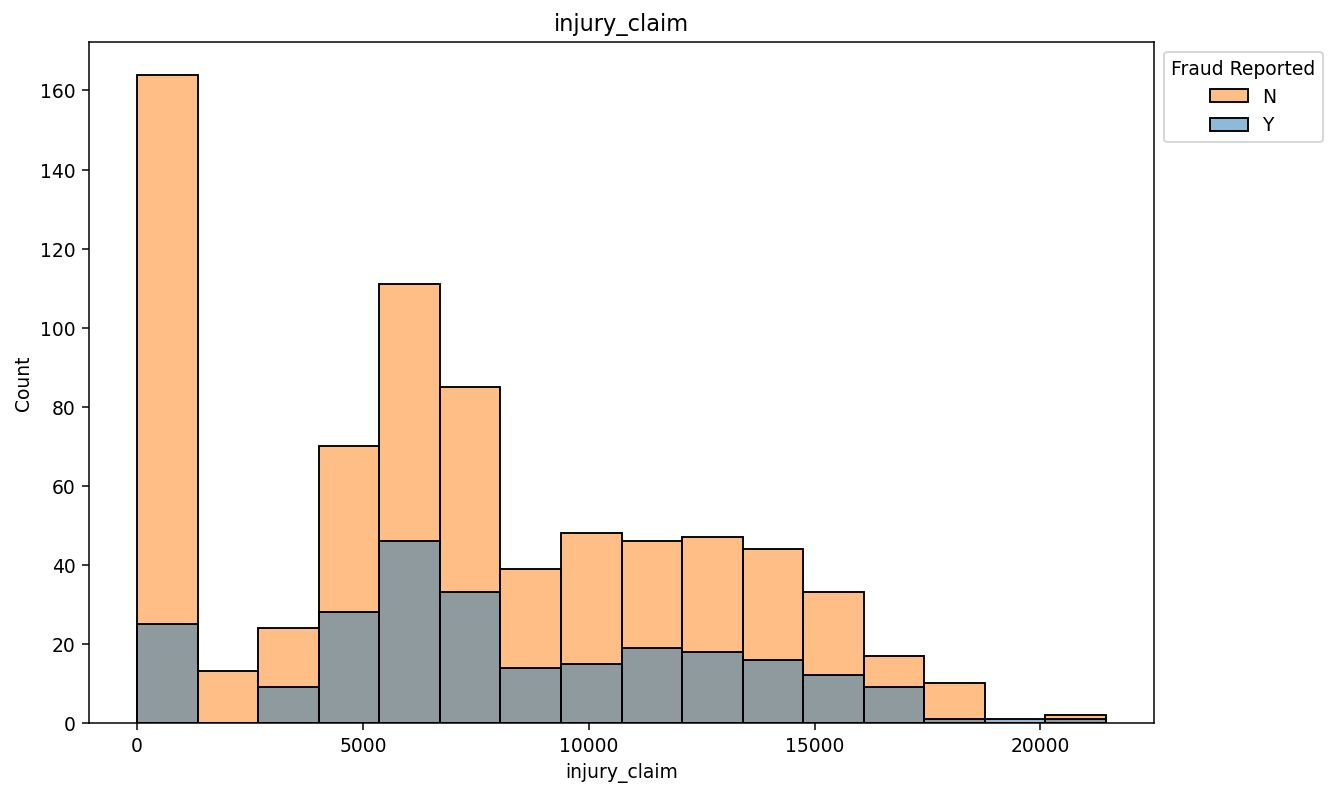

In [ ]:
visualize_numerical(df, 'injury_claim')
# Skewed distribution again, left skewed even when disregarding first binned range for injury claim

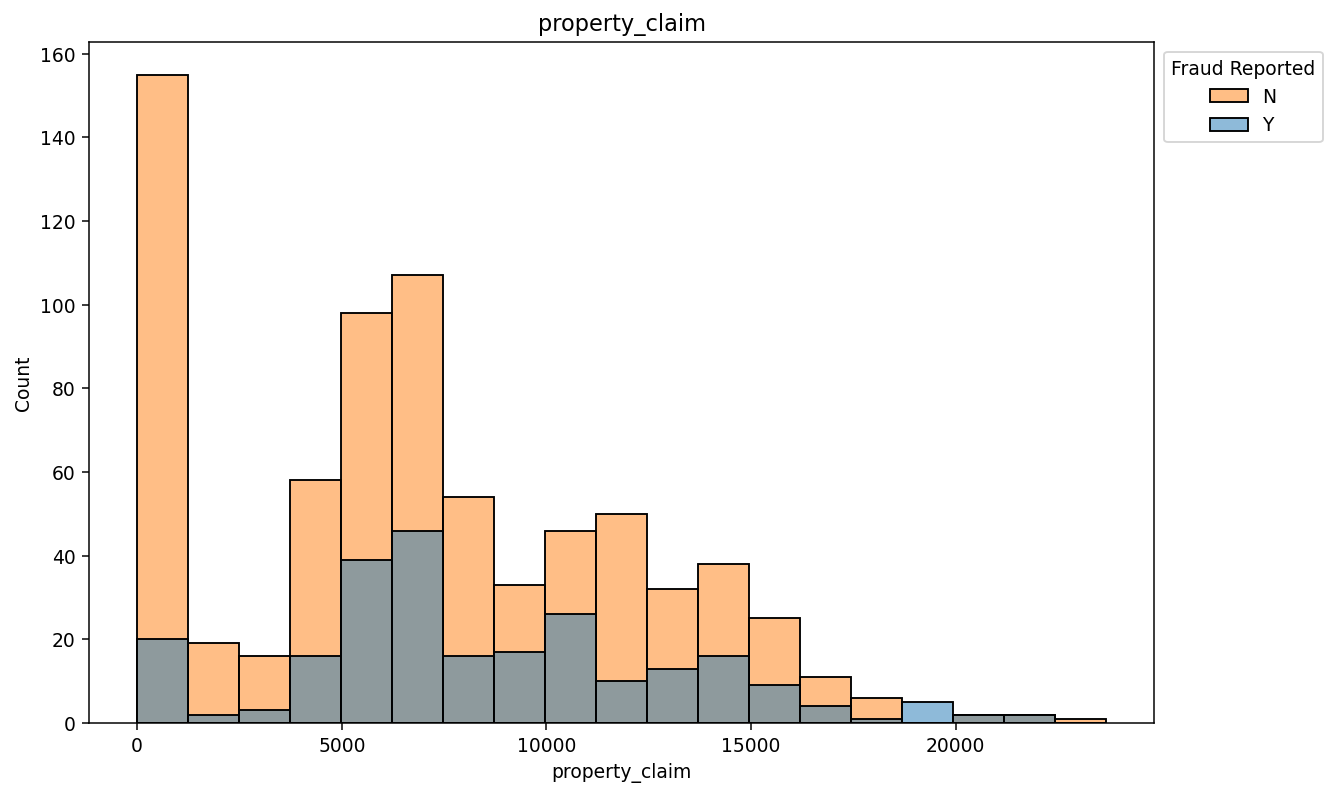

In [ ]:
visualize_numerical(df, 'property_claim')
# Same as injury claim

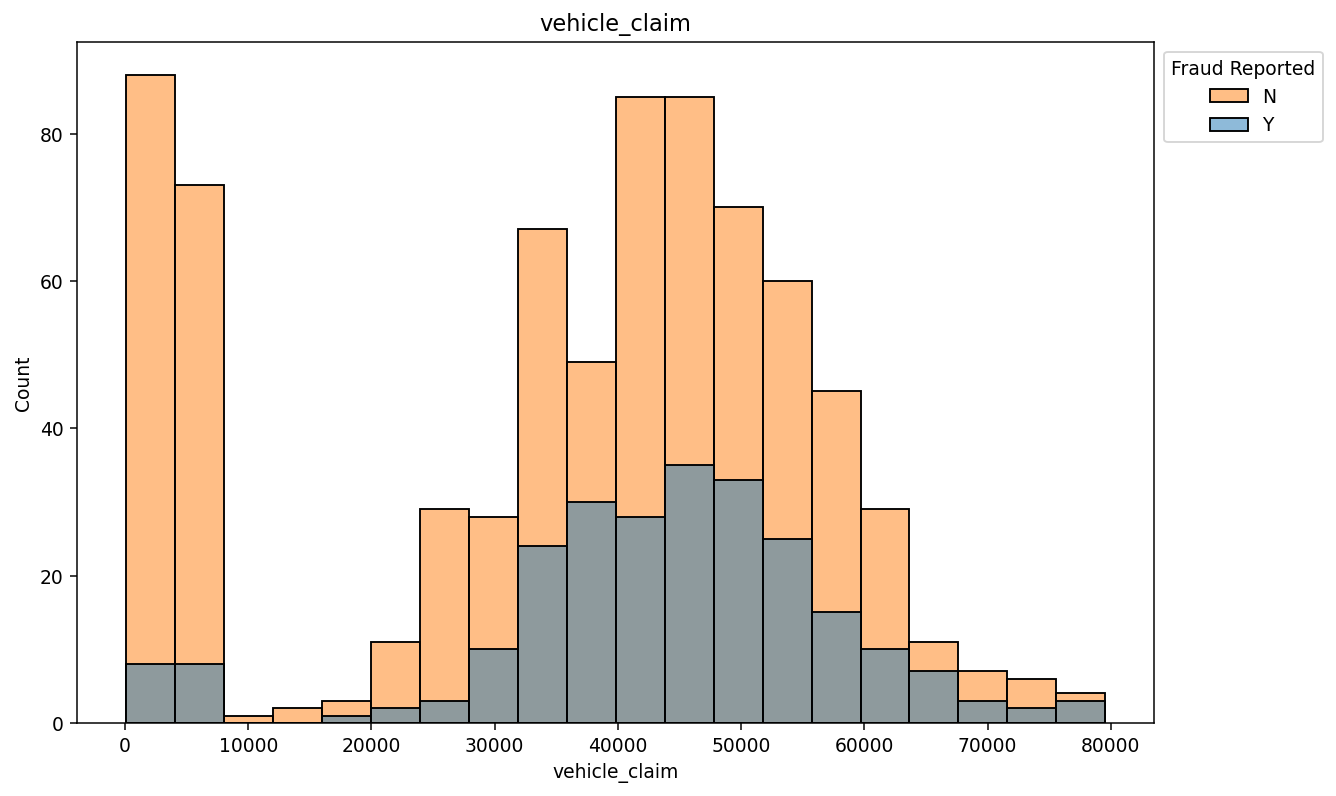

In [ ]:
visualize_numerical(df, 'vehicle_claim')
# Vehicle claim is also left skewed

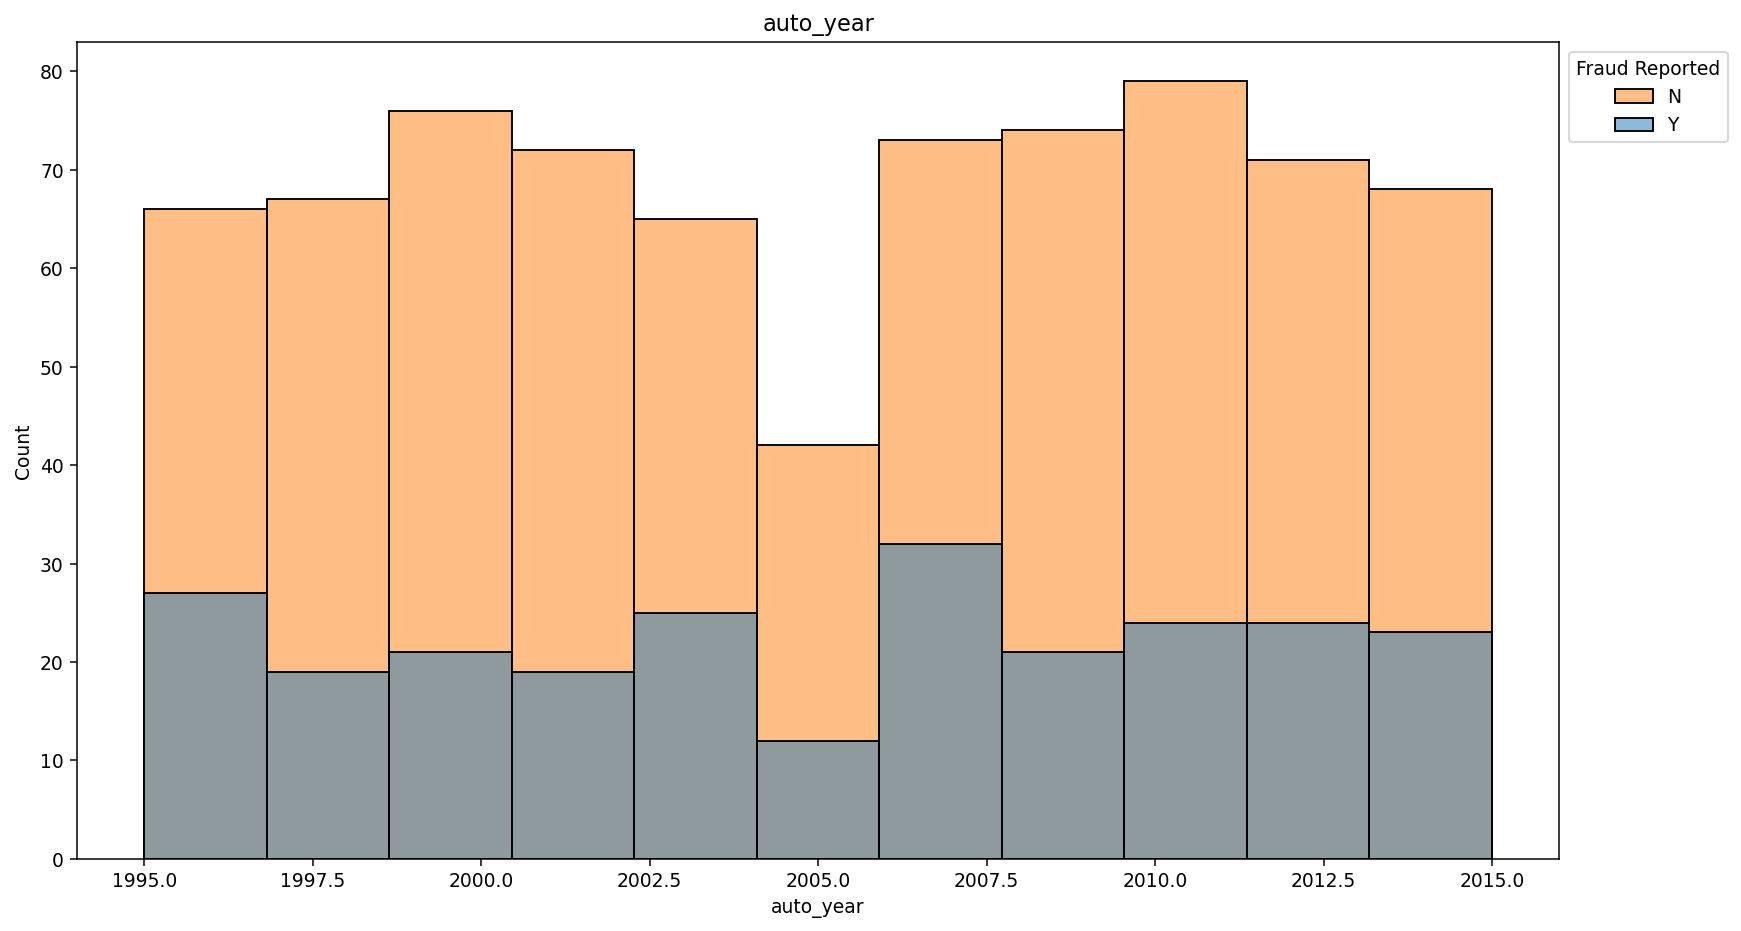

In [ ]:
visualize_numerical(df, 'auto_year', row=13, col=7)


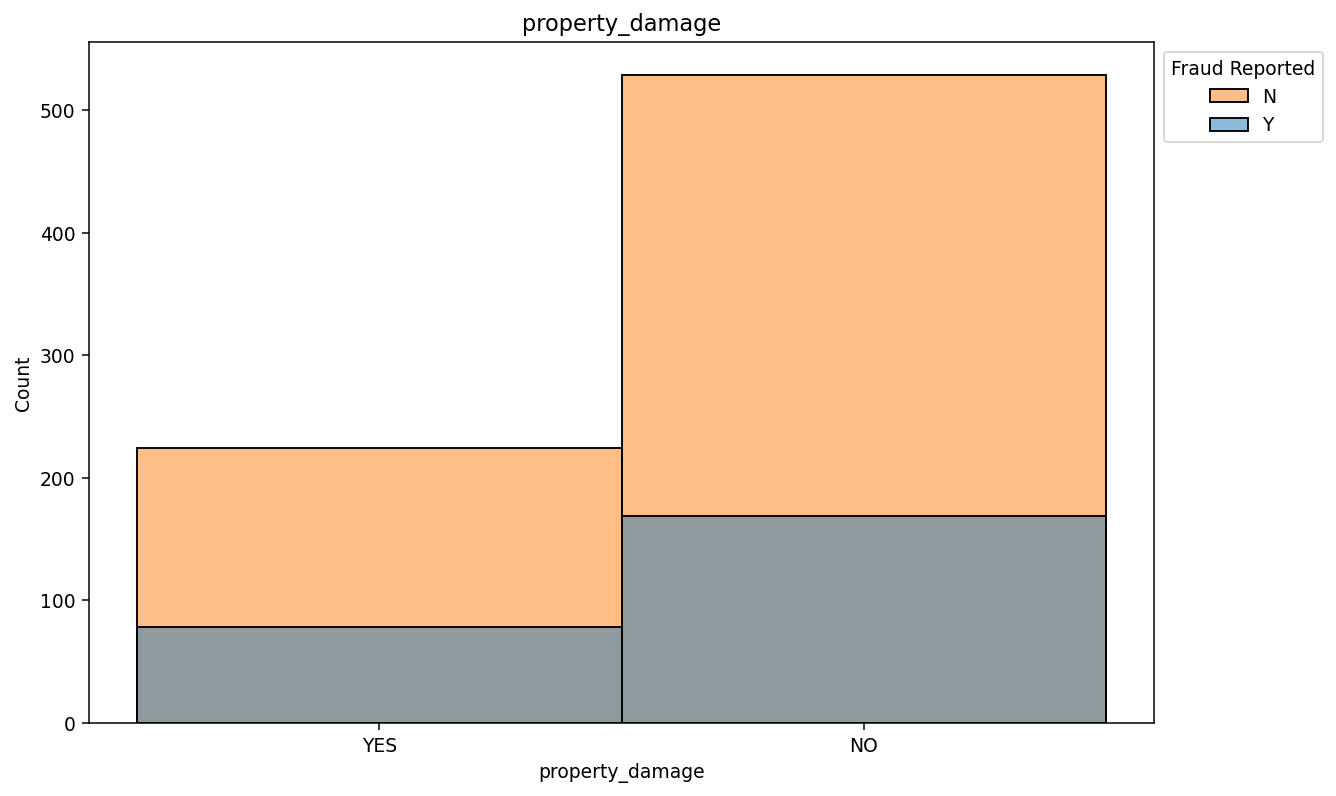

In [ ]:
visualize_numerical(df, 'property_damage')
# around the same for both relative to cases for each

In [ ]:
def csl_cols(df):
    '''
    Changes CSL columns into numerical columns representing combined single limit and split limit liablity insurance.
    '''
    single = []
    combined = []
    for csl in df['policy_csl']:
        single.append(csl.split('/')[0])
        combined.append(csl.split('/')[-1])
    df['single_csl'] = single
    df['combined_csl'] = combined
    df.drop(columns=['policy_csl'], inplace=True)
    
    return df

In [ ]:
df = csl_cols(df)

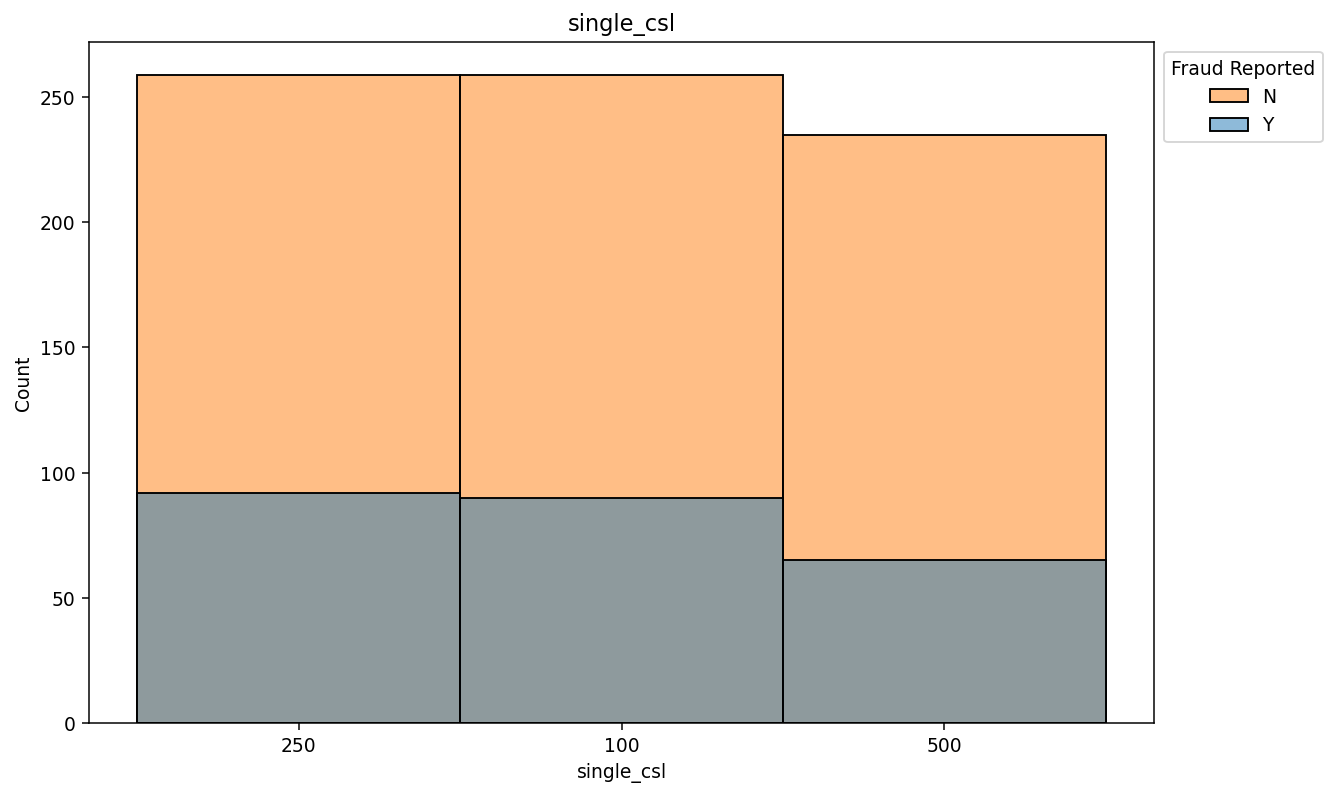

In [ ]:
visualize_numerical(df, 'single_csl')


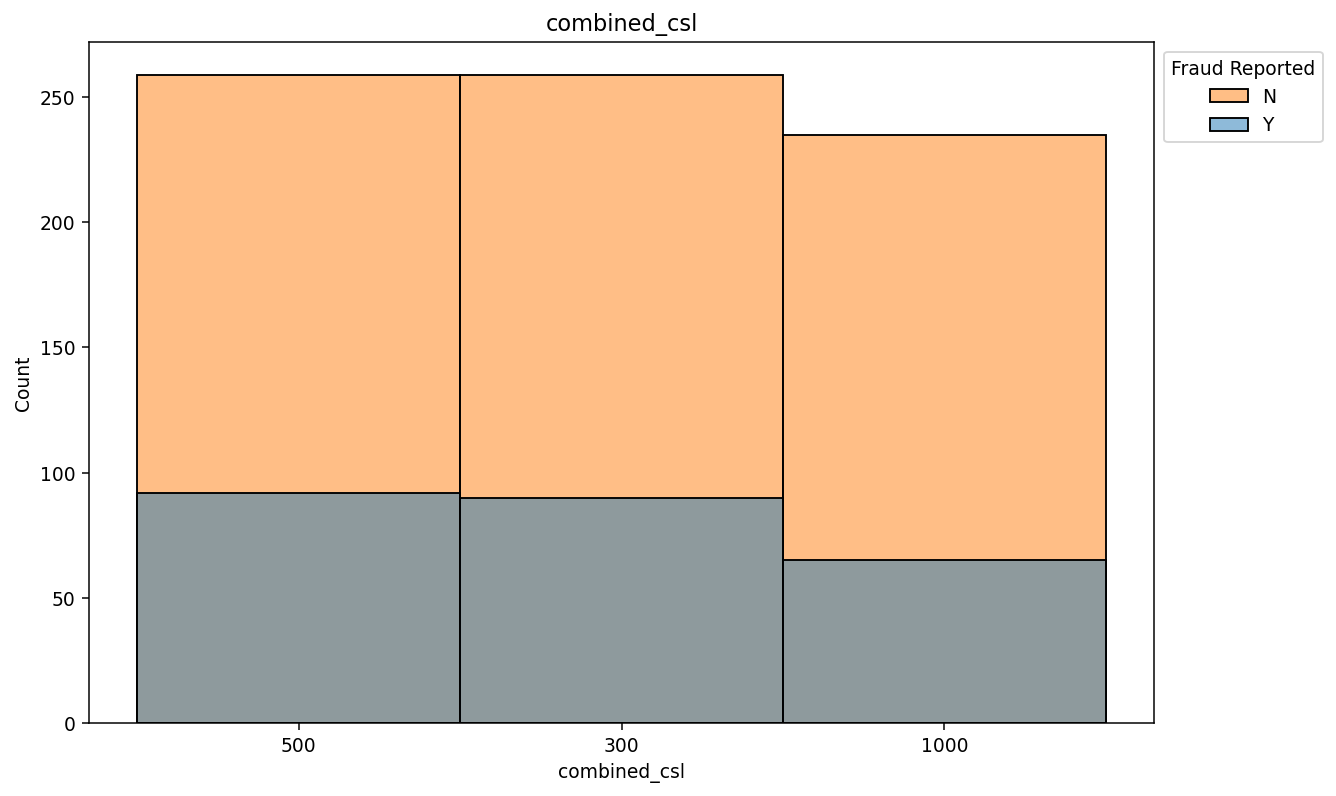

In [ ]:
visualize_numerical(df, 'combined_csl')

# Beginning encoding & cleaning categorical data

In [ ]:
def drop_columns(df):
    '''
    Drops columns with high correlation with other columns, columns with large quantities of unique values, or columns that do not seem to impact predictions based on exploratory data analysis.
    '''
    return df.drop(columns=['age', 'vehicle_claim', 'property_claim', 'injury_claim', 'policy_number', 'incident_location', 'incident_city', 'incident_state','incident_date','insured_zip', 'policy_bind_date', 'insured_relationship','auto_make', 'auto_model', 'auto_year', 'months_as_customer','bodily_injuries', 'police_report_available', 'policy_state', 'policy_deductable', 'single_csl', 'combined_csl', 'property_damage'])


In [ ]:
def scale_data(df):
    '''
    Feature scaling to reduce skewing importance of variables of higher values (e.g. total_claim_amount) and to address outliers (if any).
    '''
    df_num = df.select_dtypes('number')
    df_num_cols = df.select_dtypes('number').columns
    df_num_array = StandardScaler().fit_transform(df_num)
    df[df_num_cols] = df_num_array
    
    return df

In [ ]:
def group_hobbies(df):
    '''
    From visual analysis, crossfit and chess seem to be hobbies with higher fradulent reports as compared to other hobbies. Other hobbies will grouped into a single group, and crossfit and chess will be kept separate.
    '''
    df['insured_hobbies'] = df['insured_hobbies'].apply(lambda x: 'Other' if x != 'chess' and x != 'cross-fit' else x)

    return df

In [ ]:
def ordinal_encode_cols(df):
    '''
    Applies ordinal encoding to categorical columns with ranked / ordered data. Only severity is ordinal encoded here. Although education has ranking, the concept of distance between educational levels prevents effective ordinal encoding.
    '''
    ordinal_cols = ['incident_severity']
    severity_rank = ['Trivial Damage', 'Minor Damage', 'Major Damage', 'Total Loss']
    oe = OrdinalEncoder(categories=[severity_rank])
    df[ordinal_cols] = oe.fit_transform(df[ordinal_cols])

    return df

In [ ]:
def transform_response(df):
    '''
    Changes response variable values from 'Y' and 'N' to 1 and 0 respectively.
    '''
    df['fraud_reported'] = df['fraud_reported'].map({'Y': 1, 'N': 0})
    
    return df

In [ ]:
def return_x_y(df):
    '''
    Splits the data into X (input feature data) and y (response / target data).
    '''
    return df.drop(columns=['fraud_reported']), df['fraud_reported']

In [ ]:
def clean_transform_data(df):
    '''
    Applies all data cleaning functions (dropping columnms, transforming columns, encoding variables) and returns a finalized DataFrame.
    '''
    df = drop_columns(df)
    df = scale_data(df)
    df = group_hobbies(df)
    df = ordinal_encode_cols(df)
    df = transform_response(df)
    df = pd.get_dummies(df, drop_first=True)

    return df

In [ ]:
df = clean_transform_data(df)

In [ ]:
X, y = return_x_y(df)

In [ ]:
X

,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,incident_severity,incident_hour_of_the_day,number_of_vehicles_involved,witnesses,total_claim_amount,insured_sex_MALE,...,insured_hobbies_cross-fit,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,collision_type_Rear Collision,collision_type_Side Collision,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police
0,0.616705,-0.479476,1.011331,0.953851,2.0,-0.956261,-0.823865,0.461838,0.714257,1,...,0,0,1,0,0,1,0,0,0,1
1,-0.242521,1.697980,-0.901927,0.953851,1.0,-0.524475,-0.823865,-1.338700,-1.807312,1,...,0,0,0,1,1,0,0,0,0,1
2,0.642233,1.697980,0.358023,0.953851,1.0,-0.668404,1.140056,1.362107,-0.686362,0,...,0,0,0,0,1,0,0,0,0,1
3,0.652886,2.133471,0.853388,-1.267577,2.0,-0.956261,-0.823865,0.461838,0.403135,0,...,0,0,1,0,0,0,0,0,0,1
4,1.341980,2.133471,1.467210,-0.683741,1.0,1.202666,-0.823865,-0.438431,-1.753121,1,...,0,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.222884,-0.479476,-0.901927,0.953851,1.0,1.202666,-0.823865,-0.438431,1.305049,0,...,0,0,1,0,0,0,1,0,0,0
996,0.739141,-0.479476,1.643100,0.953851,2.0,1.634452,-0.823865,1.362107,2.111466,0,...,0,0,1,0,1,0,1,0,0,0
997,0.520739,0.826998,0.358023,0.953851,1.0,-1.100189,1.140056,1.362107,0.558507,0,...,0,0,0,0,0,1,0,0,0,1
998,0.411866,1.697980,-0.901927,0.953851,2.0,-1.388046,-0.823865,-0.438431,-0.219110,1,...,0,0,1,0,1,0,0,0,1,0


# SMOTE Oversampling & Random Undersampling to Address Class Imbalance

In [ ]:
# Using SMOTE (Synthetic Minority Oversampling Technique) to account for the classification imbalance in our data.

In [ ]:
def over_under_sample(X, y, over_ratio, under_ratio):
    '''
    Over and under samples the minority and majority classifications respectively.
    '''
    print('Original counter: ', Counter(y))
    over = SMOTE(sampling_strategy=over_ratio, random_state=89)
    under = RandomUnderSampler(sampling_strategy=under_ratio, random_state=89)
    X_over, y_over = over.fit_resample(X, y)
    X, y = under.fit_resample(X_over, y_over)
    print('New Counter', Counter(y))

    return X, y

In [ ]:
# There are 247 Fraud Reported, 753 No Fraud Reported
# Can maybe try for a 1:2 ratio of fraud reported to no fraud reported

# ~333 fraud reported, 666 no fraud reported

In [ ]:
X, y = over_under_sample(X, y, 0.5, 0.6)

Original counter:  Counter({0: 753, 1: 247})
New Counter Counter({0: 626, 1: 376})


# Model Building

In [ ]:
def split_data(X, y):
    '''
    Splits the X, y data into train and test portions.
    '''
    
    return train_test_split(X, y, test_size=0.25, random_state=89)

In [ ]:
X_train, y_train, X_test, y_test = split_data(X, y)